## Setup

In [12]:
# Setup
from kaggle.api.kaggle_api_extended import KaggleApi

import csv
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from cycler import cycler
from IPython.display import display
import datetime
from sklearn.decomposition import PCA

from typing import Tuple, List, Dict
import itertools
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from scipy import signal

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Concatenate, LSTM, GRU
from tensorflow.keras.layers import Bidirectional, Multiply

np.random.seed(2022)
tf.random.set_seed(2022)

pd.set_option('display.max_columns', None)

from xgboost import XGBClassifier
import optuna
from tqdm import tqdm

In [2]:
class KaggleLoadSubmit:
    def __init__(self, competition_name, csv_dir):
        """Kaggleのデータのダウンロードおよび提出を行うクラス

        Args:
            competition_name (string): Kaggleのコンペ名
            csv_dir (string): ダウンロード先と、提出先のcsvのディレクトリをstringで指定
        """
        self.kaggle_api = KaggleApi()
        self.csv_dir = csv_dir
        self.competition_name = competition_name
        if self.csv_dir[-1] != '\\':
            self.csv_dir += '\\'
        self.kaggle_api.authenticate()

    def download_zip(self):
        """コンペティションのzipファイルをダウンロードする
        """
        ret = self.kaggle_api.competition_download_files(self.competition_name, self.csv_dir, force=True)
        print(ret)

    def submit_csv(self, csv_name, message):
        """csvデータを提出する

        Args:
            csv_name (string): csvの名前
            message (string): 提出メッセージ
        """
        csv_path = self.csv_dir + csv_name
        self.kaggle_api.competition_submit(csv_path, message, self.competition_name)

    def read_csv(self, csv_name):
        csv_path = self.csv_dir + csv_name
        return pd.read_csv(csv_path)

In [3]:
work_dir = 'C:\\Users\\Takanori\\Desktop\\Kaggle\\TPS2204\\data'
kls = KaggleLoadSubmit('tabular-playground-series-apr-2022', work_dir)

https://www.kaggle.com/code/dmitryuarov/tps-sensors-auc-0-964

TPS Sensors

Preprocessing

前処理

In [4]:
train = kls.read_csv('train.csv')
train_labels = kls.read_csv('train_labels.csv')
test = kls.read_csv('test.csv')
ss = kls.read_csv('sample_submission.csv')

t_lbls = train_labels

In [5]:
# For DNN model
"""
features = train.columns.tolist()[3:]

def prep(df):
    # 時系列データを扱うために、各要素を1ずらした者を[項目名]_lag1として編集する
    # 欠損値を0で埋める
    for feature in features:
        df[feature + '_lag1'] = df.groupby('sequence')[feature].shift(1)
        df.fillna(0, inplace=True)
        df[feature + '_diff1'] = df[feature] - df[feature + '_lag1']

prep(train)
prep(test)

features = train.columns.tolist()[3:]
sc = StandardScaler()  # データセットの標準化をするクラス

# trainデータを用いて、正規化に必要な情報を得る(fit)
# その後、trainデータを正規化する(transform) fit_transformは両方を同時に行う
# testデータでfitするとリークする。testはtransformのみ行う
train[features] = sc.fit_transform(train[features])
test[features] = sc.transform(test[features])

groups = train["sequence"]
labels = t_lbls["state"]

train = train.drop(["sequence", "subject", "step"], axis=1).values
train = train.reshape(-1, 60, train.shape[-1])

test = test.drop(["sequence", "subject", "step"], axis=1).values
test = test.reshape(-1, 60, test.shape[-1])
"""

In [5]:
# For XGB model
def prep(df):
    
    result = pd.DataFrame()
    result['sequence'] = df['sequence'].unique()
    result = result.merge(df[['sequence', 'subject']], on='sequence', how='left')
    
    for sensor in test.columns.tolist()[3:]:
        aggs = df.groupby('sequence').agg({sensor: ['mean', 'max', 'min', 'var', 'mad', 'sum', 'median', 'skew']})
        aggs.columns = aggs.columns.map('_'.join)
        result = result.merge(aggs.reset_index(), on='sequence', how='left')
        
        aggs = df.groupby('subject').agg({sensor: ['mean', 'max', 'min', 'var', 'mad', 'sum', 'median', 'skew']})
        aggs.columns = aggs.columns.map('_subject_'.join)
        result = result.merge(aggs.reset_index(), on='subject', how='left')
    
    return result

train = prep(train)
test = prep(test)

train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)

features = train.columns.tolist()[2:]
sc = StandardScaler()
train[features] = sc.fit_transform(train[features])
test[features] = sc.transform(test[features])

X = train[features]
test = test[features]
y = t_lbls['state']

XGB

In [13]:
def objective(trial, data = X, target = y):

    params = {
        'n_estimators': 10000,
        'max_depth': trial.suggest_int('max_depth', 2, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'min_child_weight': trial.suggest_int('min_child_weight', 10, 300),
        'gamma': trial.suggest_float('gamma', 0.0001, 1.0, log = True),
        'alpha': trial.suggest_float('alpha', 0.0001, 10.0, log = True),
        'lambda': trial.suggest_float('lambda', 0.0001, 10.0, log = True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.8),
        'subsample': trial.suggest_float('subsample', 0.1, 0.8),
        'tree_method': 'gpu_hist',
        'booster': 'gbtree',
        'random_state': 2022,
        'use_label_encoder': False,
        'eval_metric': 'auc'
    }
    
    model = XGBClassifier(**params)
    scores = []
    k = StratifiedKFold(n_splits = 5, random_state = 228, shuffle = True)
    for fold, (train_idx, val_idx) in enumerate(k.split(X, y)):
        
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train, eval_set = [(X_val, y_val)], early_stopping_rounds = 50, verbose = False)
        
        val_preds = model.predict_proba(X_val)[:,1]
        val_score = roc_auc_score(y_val, val_preds)

        scores.append(val_score)
        
        print(f"Fold {fold+1} | AUC: {val_score}")
    
    return np.mean(scores)

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 150)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best value:', study.best_value)

[I 2022-04-06 12:13:29,823] A new study created in memory with name: no-name-26920405-fc76-45ab-a446-b4276ecdcf25


Fold 1 | AUC: 0.9022183381613086
Fold 2 | AUC: 0.8971862914462175
Fold 3 | AUC: 0.9023875162301966
Fold 4 | AUC: 0.8955798333437659


[I 2022-04-06 12:13:42,854] Trial 0 finished with value: 0.8991798737745839 and parameters: {'max_depth': 7, 'learning_rate': 0.14293609484109074, 'min_child_weight': 101, 'gamma': 0.671467403537458, 'alpha': 0.0031338050670213172, 'lambda': 0.00038190362409598746, 'colsample_bytree': 0.26214352592612755, 'subsample': 0.15563384526654592}. Best is trial 0 with value: 0.8991798737745839.


Fold 5 | AUC: 0.8985273896914312
Fold 1 | AUC: 0.8553882621853803
Fold 2 | AUC: 0.8528963329875141
Fold 3 | AUC: 0.8527306393047953
Fold 4 | AUC: 0.8406452477994691


[I 2022-04-06 12:13:57,948] Trial 1 finished with value: 0.8505722262729722 and parameters: {'max_depth': 2, 'learning_rate': 0.16039672778732292, 'min_child_weight': 166, 'gamma': 0.0003465067195584719, 'alpha': 0.6264799628681947, 'lambda': 0.001586664018971034, 'colsample_bytree': 0.29070790345041686, 'subsample': 0.10538758092210722}. Best is trial 0 with value: 0.8991798737745839.


Fold 5 | AUC: 0.8512006490877024
Fold 1 | AUC: 0.9414391819669523
Fold 2 | AUC: 0.9391340010405711
Fold 3 | AUC: 0.9424607743373624
Fold 4 | AUC: 0.9275404485045645


[I 2022-04-06 12:14:45,519] Trial 2 finished with value: 0.9374593025903776 and parameters: {'max_depth': 4, 'learning_rate': 0.05817653190932521, 'min_child_weight': 39, 'gamma': 0.00014308043458196402, 'alpha': 0.20578636066455028, 'lambda': 1.5826147005097813, 'colsample_bytree': 0.6495570554593418, 'subsample': 0.7046688355981063}. Best is trial 2 with value: 0.9374593025903776.


Fold 5 | AUC: 0.9367221071024375
Fold 1 | AUC: 0.921494555535407
Fold 2 | AUC: 0.9140226230073574
Fold 3 | AUC: 0.9214004029729673
Fold 4 | AUC: 0.9088172088625827


[I 2022-04-06 12:15:01,194] Trial 3 finished with value: 0.9170681538447265 and parameters: {'max_depth': 3, 'learning_rate': 0.1872051703200663, 'min_child_weight': 204, 'gamma': 0.002617547167415088, 'alpha': 0.008437000436781255, 'lambda': 0.006289241506418701, 'colsample_bytree': 0.45318609437005275, 'subsample': 0.569315870388306}. Best is trial 2 with value: 0.9374593025903776.


Fold 5 | AUC: 0.9196059788453181
Fold 1 | AUC: 0.9397720885247599
Fold 2 | AUC: 0.9367347416876262
Fold 3 | AUC: 0.9416733771990368
Fold 4 | AUC: 0.9259997579275033


[I 2022-04-06 12:15:40,676] Trial 4 finished with value: 0.9356274143117613 and parameters: {'max_depth': 7, 'learning_rate': 0.07239648884207875, 'min_child_weight': 25, 'gamma': 0.0028469795231928757, 'alpha': 0.062170085753756175, 'lambda': 0.1682878341190029, 'colsample_bytree': 0.5084226239229463, 'subsample': 0.5046526766159972}. Best is trial 2 with value: 0.9374593025903776.


Fold 5 | AUC: 0.93395710621988
Fold 1 | AUC: 0.9134229379069039
Fold 2 | AUC: 0.9041728563945085
Fold 3 | AUC: 0.916773731227499
Fold 4 | AUC: 0.9016702112290194


[I 2022-04-06 12:15:58,436] Trial 5 finished with value: 0.908411874510181 and parameters: {'max_depth': 2, 'learning_rate': 0.19523792698770673, 'min_child_weight': 249, 'gamma': 0.00031034715049138844, 'alpha': 0.003099940114342934, 'lambda': 0.014751799575163697, 'colsample_bytree': 0.48182982311127787, 'subsample': 0.482007083433336}. Best is trial 2 with value: 0.9374593025903776.


Fold 5 | AUC: 0.9060196357929743
Fold 1 | AUC: 0.9273910265639222
Fold 2 | AUC: 0.9233217083337473
Fold 3 | AUC: 0.9291808148807902
Fold 4 | AUC: 0.9162128796214413


[I 2022-04-06 12:16:21,455] Trial 6 finished with value: 0.923417958267202 and parameters: {'max_depth': 4, 'learning_rate': 0.1646169330881271, 'min_child_weight': 191, 'gamma': 0.002824323117150557, 'alpha': 0.00033247241790281175, 'lambda': 8.966900967380429, 'colsample_bytree': 0.4782479246562109, 'subsample': 0.7350654312811832}. Best is trial 2 with value: 0.9374593025903776.


Fold 5 | AUC: 0.9209833619361089
Fold 1 | AUC: 0.5
Fold 2 | AUC: 0.5
Fold 3 | AUC: 0.5436377851580866
Fold 4 | AUC: 0.5


[I 2022-04-06 12:16:23,479] Trial 7 finished with value: 0.5087275570316173 and parameters: {'max_depth': 3, 'learning_rate': 0.06634372672857117, 'min_child_weight': 282, 'gamma': 0.004650725759364645, 'alpha': 1.1181306354508522, 'lambda': 7.96815970315228, 'colsample_bytree': 0.5046772561868151, 'subsample': 0.10418959651910746}. Best is trial 2 with value: 0.9374593025903776.


Fold 5 | AUC: 0.5
Fold 1 | AUC: 0.9166505174016918
Fold 2 | AUC: 0.9145208160936533
Fold 3 | AUC: 0.9256743362207278
Fold 4 | AUC: 0.909844607849972


[I 2022-04-06 12:16:37,207] Trial 8 finished with value: 0.9167225079641232 and parameters: {'max_depth': 2, 'learning_rate': 0.17729896237109782, 'min_child_weight': 63, 'gamma': 0.03916792888132114, 'alpha': 0.002153417840840235, 'lambda': 0.0009045145582948343, 'colsample_bytree': 0.5556354681186753, 'subsample': 0.26676656186355974}. Best is trial 2 with value: 0.9374593025903776.


Fold 5 | AUC: 0.9169222622545712
Fold 1 | AUC: 0.9346591595690215
Fold 2 | AUC: 0.9298407724483804
Fold 3 | AUC: 0.9370134184452727
Fold 4 | AUC: 0.9173242326732014


[I 2022-04-06 12:17:53,967] Trial 9 finished with value: 0.9296063393695707 and parameters: {'max_depth': 8, 'learning_rate': 0.026782129921450723, 'min_child_weight': 97, 'gamma': 0.018266922979631575, 'alpha': 0.01105016008521636, 'lambda': 0.053358797875334325, 'colsample_bytree': 0.2127499369854004, 'subsample': 0.6244536387184172}. Best is trial 2 with value: 0.9374593025903776.


Fold 5 | AUC: 0.9291941137119777
Fold 1 | AUC: 0.9449544086603752
Fold 2 | AUC: 0.9385088873346714
Fold 3 | AUC: 0.9441191938820702
Fold 4 | AUC: 0.930555897535696


[I 2022-04-06 12:20:18,184] Trial 10 finished with value: 0.9392994313394875 and parameters: {'max_depth': 5, 'learning_rate': 0.017054160693132966, 'min_child_weight': 20, 'gamma': 0.0001045299570391213, 'alpha': 5.133916774620268, 'lambda': 0.6423315823557894, 'colsample_bytree': 0.7714859610515454, 'subsample': 0.7793490563556501}. Best is trial 10 with value: 0.9392994313394875.


Fold 5 | AUC: 0.9383587692846241
Fold 1 | AUC: 0.9438061922138647
Fold 2 | AUC: 0.9385916229722171
Fold 3 | AUC: 0.9435960911414597
Fold 4 | AUC: 0.9303584719885631


[I 2022-04-06 12:23:13,018] Trial 11 finished with value: 0.9387300003874403 and parameters: {'max_depth': 5, 'learning_rate': 0.01615813520924614, 'min_child_weight': 21, 'gamma': 0.00017483107383044812, 'alpha': 9.422032194454934, 'lambda': 0.8051534798064288, 'colsample_bytree': 0.7907471306616078, 'subsample': 0.7809753671019751}. Best is trial 10 with value: 0.9392994313394875.


Fold 5 | AUC: 0.9372976236210967
Fold 1 | AUC: 0.9442059328569165
Fold 2 | AUC: 0.9376395700534357
Fold 3 | AUC: 0.944265093285914
Fold 4 | AUC: 0.9307992308265085


[I 2022-04-06 12:26:32,304] Trial 12 finished with value: 0.9387354348940213 and parameters: {'max_depth': 5, 'learning_rate': 0.011164582132791437, 'min_child_weight': 15, 'gamma': 0.00011822480211126793, 'alpha': 5.352360913713088, 'lambda': 0.41715387681312943, 'colsample_bytree': 0.766348649096068, 'subsample': 0.7780859768612239}. Best is trial 10 with value: 0.9392994313394875.


Fold 5 | AUC: 0.9367673474473321
Fold 1 | AUC: 0.9327470470568577
Fold 2 | AUC: 0.9280979862768562
Fold 3 | AUC: 0.9326589736362446
Fold 4 | AUC: 0.9177404431053985


[I 2022-04-06 12:27:36,073] Trial 13 finished with value: 0.9274956427224463 and parameters: {'max_depth': 6, 'learning_rate': 0.041356670872751106, 'min_child_weight': 100, 'gamma': 0.0007254062979194295, 'alpha': 8.479550961847519, 'lambda': 0.2766782356936645, 'colsample_bytree': 0.7949558368271377, 'subsample': 0.38748662007267043}. Best is trial 10 with value: 0.9392994313394875.


Fold 5 | AUC: 0.9262337635368754
Fold 1 | AUC: 0.9372552496725788
Fold 2 | AUC: 0.9361185984227147
Fold 3 | AUC: 0.939825837034814
Fold 4 | AUC: 0.9258458668642799


[I 2022-04-06 12:28:05,138] Trial 14 finished with value: 0.9341362915397351 and parameters: {'max_depth': 5, 'learning_rate': 0.10402793100258824, 'min_child_weight': 68, 'gamma': 0.09208075026307254, 'alpha': 1.8475061855994643, 'lambda': 1.2356519974062092, 'colsample_bytree': 0.663102466630766, 'subsample': 0.6721736289430756}. Best is trial 10 with value: 0.9392994313394875.


Fold 5 | AUC: 0.9316359057042883
Fold 1 | AUC: 0.9357888420465474
Fold 2 | AUC: 0.9317663776899646
Fold 3 | AUC: 0.9365221941313151
Fold 4 | AUC: 0.9218312013055303


[I 2022-04-06 12:28:38,892] Trial 15 finished with value: 0.9311701059074184 and parameters: {'max_depth': 9, 'learning_rate': 0.10014988840142866, 'min_child_weight': 124, 'gamma': 0.0009301542824730795, 'alpha': 2.2555655840306974, 'lambda': 0.0735272180229827, 'colsample_bytree': 0.6928577572219405, 'subsample': 0.7850641507430524}. Best is trial 10 with value: 0.9392994313394875.


Fold 5 | AUC: 0.9299419143637353
Fold 1 | AUC: 0.9419406370317893
Fold 2 | AUC: 0.9381521454996632
Fold 3 | AUC: 0.9435296653966202
Fold 4 | AUC: 0.9276341181011192


[I 2022-04-06 12:31:22,155] Trial 16 finished with value: 0.9377950294702616 and parameters: {'max_depth': 6, 'learning_rate': 0.011437591530701043, 'min_child_weight': 10, 'gamma': 0.00011828824881536392, 'alpha': 0.2302918498377682, 'lambda': 0.4052067659788083, 'colsample_bytree': 0.7230722643962255, 'subsample': 0.35635334771186533}. Best is trial 10 with value: 0.9392994313394875.


Fold 5 | AUC: 0.9377185813221158
Fold 1 | AUC: 0.9323407824567235
Fold 2 | AUC: 0.9285499185765673
Fold 3 | AUC: 0.9372613288144057
Fold 4 | AUC: 0.9201960253238683


[I 2022-04-06 12:32:17,072] Trial 17 finished with value: 0.9289868645152237 and parameters: {'max_depth': 4, 'learning_rate': 0.03998871175594475, 'min_child_weight': 71, 'gamma': 0.0007780503826479983, 'alpha': 0.10237540521941091, 'lambda': 2.5495510227158777, 'colsample_bytree': 0.10308580907677795, 'subsample': 0.5803092253358967}. Best is trial 10 with value: 0.9392994313394875.


Fold 5 | AUC: 0.9265862674045542
Fold 1 | AUC: 0.9343970151117087
Fold 2 | AUC: 0.9291074944994887
Fold 3 | AUC: 0.9362223145131504
Fold 4 | AUC: 0.9188063333996858


[I 2022-04-06 12:32:56,810] Trial 18 finished with value: 0.9293552074722455 and parameters: {'max_depth': 7, 'learning_rate': 0.0826814052330902, 'min_child_weight': 136, 'gamma': 0.8600517107652982, 'alpha': 3.5488585237090398, 'lambda': 0.013794059818022028, 'colsample_bytree': 0.6144891983222485, 'subsample': 0.656418753999652}. Best is trial 10 with value: 0.9392994313394875.


Fold 5 | AUC: 0.9282428798371941
Fold 1 | AUC: 0.9399354098594488
Fold 2 | AUC: 0.9365708272659297
Fold 3 | AUC: 0.940690261348238
Fold 4 | AUC: 0.9264881302895882


[I 2022-04-06 12:33:20,566] Trial 19 finished with value: 0.9352380078126933 and parameters: {'max_depth': 5, 'learning_rate': 0.12238187632465912, 'min_child_weight': 47, 'gamma': 0.11236721777439805, 'alpha': 0.4653179680456204, 'lambda': 0.26491294123056663, 'colsample_bytree': 0.38463159241428174, 'subsample': 0.7344092971902118}. Best is trial 10 with value: 0.9392994313394875.


Fold 5 | AUC: 0.9325054103002623
Fold 1 | AUC: 0.9305539595748928
Fold 2 | AUC: 0.9234321707888933
Fold 3 | AUC: 0.9325806861512552
Fold 4 | AUC: 0.9183496292226596


[I 2022-04-06 12:34:16,128] Trial 20 finished with value: 0.9262922807031702 and parameters: {'max_depth': 6, 'learning_rate': 0.04463990266141151, 'min_child_weight': 156, 'gamma': 0.009655434194566761, 'alpha': 4.408568418599982, 'lambda': 3.3111551783866418, 'colsample_bytree': 0.7422408989304593, 'subsample': 0.5539765692974988}. Best is trial 10 with value: 0.9392994313394875.


Fold 5 | AUC: 0.9265449577781502
Fold 1 | AUC: 0.9448168124746363
Fold 2 | AUC: 0.9386642761306351
Fold 3 | AUC: 0.9441028098534882
Fold 4 | AUC: 0.9317365201069983


[I 2022-04-06 12:38:15,444] Trial 21 finished with value: 0.939470795303728 and parameters: {'max_depth': 5, 'learning_rate': 0.01076412460557389, 'min_child_weight': 10, 'gamma': 0.00010852252007639975, 'alpha': 5.570222817743966, 'lambda': 0.6811860051134496, 'colsample_bytree': 0.782782766740745, 'subsample': 0.7948593388984554}. Best is trial 21 with value: 0.939470795303728.


Fold 5 | AUC: 0.9380335579528819
Fold 1 | AUC: 0.9432888720715773
Fold 2 | AUC: 0.9396998060457212
Fold 3 | AUC: 0.9433994086625992
Fold 4 | AUC: 0.9285312844586194


[I 2022-04-06 12:40:00,318] Trial 22 finished with value: 0.9385394864978988 and parameters: {'max_depth': 5, 'learning_rate': 0.026281032285062296, 'min_child_weight': 44, 'gamma': 0.00010209036398225325, 'alpha': 0.7504032416553531, 'lambda': 0.10174443449080488, 'colsample_bytree': 0.6176400699992104, 'subsample': 0.798029946577545}. Best is trial 21 with value: 0.939470795303728.


Fold 5 | AUC: 0.9377780612509771
Fold 1 | AUC: 0.9433904382216107
Fold 2 | AUC: 0.9399509783933955
Fold 3 | AUC: 0.9442650932859141
Fold 4 | AUC: 0.9296298812391146


[I 2022-04-06 12:43:20,143] Trial 23 finished with value: 0.9389923887850269 and parameters: {'max_depth': 4, 'learning_rate': 0.011978059641197015, 'min_child_weight': 10, 'gamma': 0.00031294264443006495, 'alpha': 3.952829201003574, 'lambda': 0.7861698443096777, 'colsample_bytree': 0.7488207929010066, 'subsample': 0.7171674121213303}. Best is trial 21 with value: 0.939470795303728.


Fold 5 | AUC: 0.9377255527850995
Fold 1 | AUC: 0.9379169865011914
Fold 2 | AUC: 0.9358115276245843
Fold 3 | AUC: 0.9394756932927643
Fold 4 | AUC: 0.925956223443594


[I 2022-04-06 12:44:48,454] Trial 24 finished with value: 0.9342053086347771 and parameters: {'max_depth': 3, 'learning_rate': 0.030570490347046606, 'min_child_weight': 71, 'gamma': 0.00039526050740752467, 'alpha': 1.818134992717812, 'lambda': 0.7255231846490868, 'colsample_bytree': 0.7097116240130765, 'subsample': 0.7083480870090625}. Best is trial 21 with value: 0.939470795303728.


Fold 5 | AUC: 0.931866112311752
Fold 1 | AUC: 0.9427159500223372
Fold 2 | AUC: 0.9371842275034314
Fold 3 | AUC: 0.9424573640870694
Fold 4 | AUC: 0.9269845865677652


[I 2022-04-06 12:45:46,040] Trial 25 finished with value: 0.9368619006434258 and parameters: {'max_depth': 4, 'learning_rate': 0.05527291081241617, 'min_child_weight': 45, 'gamma': 0.00028331305855906633, 'alpha': 0.31113780025851057, 'lambda': 3.983139780784084, 'colsample_bytree': 0.5734495218542105, 'subsample': 0.6320023353933282}. Best is trial 21 with value: 0.939470795303728.


Fold 5 | AUC: 0.934967375036526
Fold 1 | AUC: 0.9417375047317222
Fold 2 | AUC: 0.9365322766104426
Fold 3 | AUC: 0.9417455114063236
Fold 4 | AUC: 0.9286598854724166


[I 2022-04-06 12:46:18,403] Trial 26 finished with value: 0.9369245867561293 and parameters: {'max_depth': 4, 'learning_rate': 0.08331117412948202, 'min_child_weight': 32, 'gamma': 0.0012121347596929276, 'alpha': 0.03117031135389218, 'lambda': 0.13230653933022718, 'colsample_bytree': 0.7992830897556399, 'subsample': 0.7281962253700112}. Best is trial 21 with value: 0.939470795303728.


Fold 5 | AUC: 0.9359477555597416
Fold 1 | AUC: 0.9385592997303085
Fold 2 | AUC: 0.9366947824504962
Fold 3 | AUC: 0.9412634058051058
Fold 4 | AUC: 0.9274365442252509


[I 2022-04-06 12:48:26,932] Trial 27 finished with value: 0.9352781532369168 and parameters: {'max_depth': 6, 'learning_rate': 0.024747794251620145, 'min_child_weight': 82, 'gamma': 0.0005523306102185625, 'alpha': 9.770871588383612, 'lambda': 0.026692709498067388, 'colsample_bytree': 0.6898173789783401, 'subsample': 0.6700762458255104}. Best is trial 21 with value: 0.939470795303728.


Fold 5 | AUC: 0.9324367339734224
Fold 1 | AUC: 0.9328589922295223
Fold 2 | AUC: 0.9269702313321047
Fold 3 | AUC: 0.9349009907963277
Fold 4 | AUC: 0.9163345833490314


[I 2022-04-06 12:49:19,168] Trial 28 finished with value: 0.9277100619343891 and parameters: {'max_depth': 3, 'learning_rate': 0.050444048192205285, 'min_child_weight': 122, 'gamma': 0.00026130908453655635, 'alpha': 0.00011104993098312329, 'lambda': 0.6787365165352397, 'colsample_bytree': 0.39441651676349826, 'subsample': 0.7464710328087173}. Best is trial 21 with value: 0.939470795303728.


Fold 5 | AUC: 0.9274855119649589
Fold 1 | AUC: 0.9301435433657064
Fold 2 | AUC: 0.9226870310998517
Fold 3 | AUC: 0.9299991266793817
Fold 4 | AUC: 0.9169471810272121


[I 2022-04-06 12:49:47,986] Trial 29 finished with value: 0.924613470673777 and parameters: {'max_depth': 7, 'learning_rate': 0.12543163006748076, 'min_child_weight': 10, 'gamma': 0.0015261954111111299, 'alpha': 1.1153168341802933, 'lambda': 0.00010455685775655808, 'colsample_bytree': 0.7354017420452119, 'subsample': 0.24772504505395868}. Best is trial 21 with value: 0.939470795303728.


Fold 5 | AUC: 0.923290471196733
Fold 1 | AUC: 0.9410386999651413
Fold 2 | AUC: 0.9359458618317819
Fold 3 | AUC: 0.941497007950183
Fold 4 | AUC: 0.9268822397401755


[I 2022-04-06 12:51:04,569] Trial 30 finished with value: 0.9360108211904906 and parameters: {'max_depth': 8, 'learning_rate': 0.03645855240173491, 'min_child_weight': 54, 'gamma': 0.4388190454980113, 'alpha': 2.599002505849398, 'lambda': 1.73182710688745, 'colsample_bytree': 0.5671172257647419, 'subsample': 0.598211100995331}. Best is trial 21 with value: 0.939470795303728.


Fold 5 | AUC: 0.9346902964651717
Fold 1 | AUC: 0.9435474580068451
Fold 2 | AUC: 0.939237642995131
Fold 3 | AUC: 0.9440429822016072
Fold 4 | AUC: 0.9277680589493995


[I 2022-04-06 12:56:17,119] Trial 31 finished with value: 0.9383768545436203 and parameters: {'max_depth': 5, 'learning_rate': 0.010391788369064342, 'min_child_weight': 27, 'gamma': 0.00017568726099573715, 'alpha': 4.3724748022935875, 'lambda': 0.34034954529876954, 'colsample_bytree': 0.7620496647741658, 'subsample': 0.7725267887412964}. Best is trial 21 with value: 0.939470795303728.


Fold 5 | AUC: 0.9372881305651187
Fold 1 | AUC: 0.9444668911402142
Fold 2 | AUC: 0.9398038928155368
Fold 3 | AUC: 0.9445390994833767
Fold 4 | AUC: 0.9304342679724735


[I 2022-04-06 13:00:08,339] Trial 32 finished with value: 0.9394299847862563 and parameters: {'max_depth': 5, 'learning_rate': 0.0196562858935325, 'min_child_weight': 11, 'gamma': 0.00010470129670508499, 'alpha': 5.0241365043003015, 'lambda': 0.6271341323902929, 'colsample_bytree': 0.7522049201587605, 'subsample': 0.6903631895671284}. Best is trial 21 with value: 0.939470795303728.


Fold 5 | AUC: 0.9379057725196797
Fold 1 | AUC: 0.9432225945984897
Fold 2 | AUC: 0.9400354932919635
Fold 3 | AUC: 0.9431020496642164
Fold 4 | AUC: 0.9290571839908203


[I 2022-04-06 13:03:27,767] Trial 33 finished with value: 0.9384574328663167 and parameters: {'max_depth': 4, 'learning_rate': 0.02256241195040548, 'min_child_weight': 37, 'gamma': 0.00023341174243668997, 'alpha': 0.9435020570533118, 'lambda': 5.081373394762349, 'colsample_bytree': 0.6533004857594678, 'subsample': 0.6911173546832248}. Best is trial 21 with value: 0.939470795303728.


Fold 5 | AUC: 0.9368698427860933
Fold 1 | AUC: 0.9429994456119198
Fold 2 | AUC: 0.9383464556304939
Fold 3 | AUC: 0.9444479123559745
Fold 4 | AUC: 0.9312098789311194


[I 2022-04-06 13:05:44,720] Trial 34 finished with value: 0.9386665455565721 and parameters: {'max_depth': 5, 'learning_rate': 0.03212525336799693, 'min_child_weight': 33, 'gamma': 0.0004122208842846593, 'alpha': 0.4901758244869691, 'lambda': 1.3588402999347118, 'colsample_bytree': 0.6191936896324202, 'subsample': 0.7090641712703433}. Best is trial 21 with value: 0.939470795303728.


Fold 5 | AUC: 0.9363290352533532
Fold 1 | AUC: 0.9384096935326679
Fold 2 | AUC: 0.9343876739913407
Fold 3 | AUC: 0.940368659918424
Fold 4 | AUC: 0.9235797004412187


[I 2022-04-06 13:07:03,537] Trial 35 finished with value: 0.9335151820923633 and parameters: {'max_depth': 6, 'learning_rate': 0.06276805913887179, 'min_child_weight': 87, 'gamma': 0.00010250915477061133, 'alpha': 5.324416117541909, 'lambda': 0.1829525472415839, 'colsample_bytree': 0.6856346516992575, 'subsample': 0.6464154460956595}. Best is trial 21 with value: 0.939470795303728.


Fold 5 | AUC: 0.9308301825781656
Fold 1 | AUC: 0.9177256358745283
Fold 2 | AUC: 0.9135916711605364
Fold 3 | AUC: 0.9230548191803745
Fold 4 | AUC: 0.9084670788821116


[I 2022-04-06 13:08:32,626] Trial 36 finished with value: 0.9156169809338056 and parameters: {'max_depth': 3, 'learning_rate': 0.05151271315201154, 'min_child_weight': 220, 'gamma': 0.0001918136516132564, 'alpha': 0.10115640964205781, 'lambda': 0.005114799514724033, 'colsample_bytree': 0.7457006161942428, 'subsample': 0.5324638372963222}. Best is trial 21 with value: 0.939470795303728.


Fold 5 | AUC: 0.9152456995714776
Fold 1 | AUC: 0.934767768627269
Fold 2 | AUC: 0.9335555729198252
Fold 3 | AUC: 0.9382932260715711
Fold 4 | AUC: 0.9241037458642241


[I 2022-04-06 13:11:13,320] Trial 37 finished with value: 0.9323536782723094 and parameters: {'max_depth': 4, 'learning_rate': 0.020698620136017414, 'min_child_weight': 55, 'gamma': 0.00055904712062612, 'alpha': 1.5426470065578426, 'lambda': 0.03869482075871476, 'colsample_bytree': 0.768076312275763, 'subsample': 0.4398230548550675}. Best is trial 21 with value: 0.939470795303728.


Fold 5 | AUC: 0.9310480778786581
Fold 1 | AUC: 0.9406517106927507
Fold 2 | AUC: 0.9371941617108068
Fold 3 | AUC: 0.9413625254712337
Fold 4 | AUC: 0.9259553334711802


[I 2022-04-06 13:11:51,575] Trial 38 finished with value: 0.9361644935699773 and parameters: {'max_depth': 4, 'learning_rate': 0.13881183482922263, 'min_child_weight': 27, 'gamma': 0.0003667929544335404, 'alpha': 3.149914766528593, 'lambda': 2.007347259396285, 'colsample_bytree': 0.7110370082982789, 'subsample': 0.7479343661304971}. Best is trial 21 with value: 0.939470795303728.


Fold 5 | AUC: 0.9356587365039152
Fold 1 | AUC: 0.929256285202494
Fold 2 | AUC: 0.9208906446900252
Fold 3 | AUC: 0.9305539595748931
Fold 4 | AUC: 0.9124683948546541


[I 2022-04-06 13:12:52,648] Trial 39 finished with value: 0.923185525046508 and parameters: {'max_depth': 6, 'learning_rate': 0.08073856948313231, 'min_child_weight': 180, 'gamma': 0.0016835022538980592, 'alpha': 0.0008276888411899124, 'lambda': 0.7246392049956082, 'colsample_bytree': 0.648241274551796, 'subsample': 0.6112936214283188}. Best is trial 21 with value: 0.939470795303728.


Fold 5 | AUC: 0.9227583409104732
Fold 1 | AUC: 0.939424242994864
Fold 2 | AUC: 0.9374451857867292
Fold 3 | AUC: 0.9431480139072972
Fold 4 | AUC: 0.9281832310804472


[I 2022-04-06 13:15:00,238] Trial 40 finished with value: 0.936941718759255 and parameters: {'max_depth': 3, 'learning_rate': 0.0358664674231269, 'min_child_weight': 11, 'gamma': 0.00016476722883149454, 'alpha': 0.010979541811450659, 'lambda': 6.7749996074025765, 'colsample_bytree': 0.24435783763207386, 'subsample': 0.6876466510917428}. Best is trial 21 with value: 0.939470795303728.


Fold 5 | AUC: 0.9365079200269366
Fold 1 | AUC: 0.9431244386987494
Fold 2 | AUC: 0.9392088782752674
Fold 3 | AUC: 0.9432407578880943
Fold 4 | AUC: 0.9299996647770574


[I 2022-04-06 13:20:56,107] Trial 41 finished with value: 0.9386194833311476 and parameters: {'max_depth': 5, 'learning_rate': 0.010063146085852518, 'min_child_weight': 19, 'gamma': 0.00010154816898953487, 'alpha': 6.453861372890349, 'lambda': 0.5508831607016481, 'colsample_bytree': 0.7691042295278557, 'subsample': 0.7625960083962318}. Best is trial 21 with value: 0.939470795303728.


Fold 5 | AUC: 0.9375236770165698
Fold 1 | AUC: 0.9437938856584591
Fold 2 | AUC: 0.9393708651641894
Fold 3 | AUC: 0.943608694240369
Fold 4 | AUC: 0.9305642039448918


[I 2022-04-06 13:24:22,027] Trial 42 finished with value: 0.9387957240295071 and parameters: {'max_depth': 5, 'learning_rate': 0.019215329243497184, 'min_child_weight': 23, 'gamma': 0.0001648590258224683, 'alpha': 6.026882536637007, 'lambda': 1.19513928991927, 'colsample_bytree': 0.7577523603779976, 'subsample': 0.7936189220478324}. Best is trial 21 with value: 0.939470795303728.


Fold 5 | AUC: 0.9366409711396264
Fold 1 | AUC: 0.9423924210597486
Fold 2 | AUC: 0.9382448153445844
Fold 3 | AUC: 0.9436405726670218
Fold 4 | AUC: 0.9290264799425434


[I 2022-04-06 13:27:49,174] Trial 43 finished with value: 0.9378157592604088 and parameters: {'max_depth': 5, 'learning_rate': 0.019919226095974976, 'min_child_weight': 57, 'gamma': 0.00023406989065017741, 'alpha': 3.1186541658240863, 'lambda': 1.1231410155488755, 'colsample_bytree': 0.7244804311164929, 'subsample': 0.7922167564284671}. Best is trial 21 with value: 0.939470795303728.


Fold 5 | AUC: 0.9357745072881454
Fold 1 | AUC: 0.9232923505268763
Fold 2 | AUC: 0.9156661412410019
Fold 3 | AUC: 0.9251451543382905
Fold 4 | AUC: 0.9092864468177702


[I 2022-04-06 13:29:37,489] Trial 44 finished with value: 0.9185603818217419 and parameters: {'max_depth': 4, 'learning_rate': 0.046726940119701826, 'min_child_weight': 290, 'gamma': 0.005043244520224009, 'alpha': 6.7923986753595385, 'lambda': 0.1866077565892098, 'colsample_bytree': 0.7964337199049376, 'subsample': 0.7186600187656557}. Best is trial 21 with value: 0.939470795303728.


Fold 5 | AUC: 0.9194118161847703
Fold 1 | AUC: 0.9435496820831232
Fold 2 | AUC: 0.9394513025895809
Fold 3 | AUC: 0.9445702365512703
Fold 4 | AUC: 0.9300239906897019


[I 2022-04-06 13:31:56,798] Trial 45 finished with value: 0.9390017954283005 and parameters: {'max_depth': 5, 'learning_rate': 0.030530278763201288, 'min_child_weight': 38, 'gamma': 0.00018025414721984856, 'alpha': 1.3007218300696348, 'lambda': 9.917184153559507, 'colsample_bytree': 0.6715933257575514, 'subsample': 0.7523871356145474}. Best is trial 21 with value: 0.939470795303728.


Fold 5 | AUC: 0.937413765227826
Fold 1 | AUC: 0.9424450575316639
Fold 2 | AUC: 0.9388331576560193
Fold 3 | AUC: 0.9432922823218703
Fold 4 | AUC: 0.9296011054644009


[I 2022-04-06 13:34:13,258] Trial 46 finished with value: 0.9383385516795061 and parameters: {'max_depth': 4, 'learning_rate': 0.030991703257714814, 'min_child_weight': 41, 'gamma': 0.00047433732998671365, 'alpha': 1.2766589683552543, 'lambda': 8.84115829215379, 'colsample_bytree': 0.6706300601240363, 'subsample': 0.757859775411622}. Best is trial 21 with value: 0.939470795303728.


Fold 5 | AUC: 0.9375211554235757
Fold 1 | AUC: 0.9241312720989778
Fold 2 | AUC: 0.9177947305109017
Fold 3 | AUC: 0.9275800730475614
Fold 4 | AUC: 0.9106169555764336


[I 2022-04-06 13:35:23,619] Trial 47 finished with value: 0.9197321192589364 and parameters: {'max_depth': 6, 'learning_rate': 0.07262175715957302, 'min_child_weight': 242, 'gamma': 0.00029017670567849986, 'alpha': 0.619338704184245, 'lambda': 2.5989281659348595, 'colsample_bytree': 0.5387193381105628, 'subsample': 0.7030127797007609}. Best is trial 21 with value: 0.939470795303728.


Fold 5 | AUC: 0.9185375650608075
Fold 1 | AUC: 0.9420433893558378
Fold 2 | AUC: 0.9400400155803956
Fold 3 | AUC: 0.943902494716707
Fold 4 | AUC: 0.9299705923448727


[I 2022-04-06 13:38:19,314] Trial 48 finished with value: 0.9386796879471146 and parameters: {'max_depth': 5, 'learning_rate': 0.02080846353902667, 'min_child_weight': 30, 'gamma': 0.00015470097824262, 'alpha': 2.1480585441267066, 'lambda': 0.07940661963868349, 'colsample_bytree': 0.6365548122321574, 'subsample': 0.6674201716100829}. Best is trial 21 with value: 0.939470795303728.


Fold 5 | AUC: 0.9374419477377602
Fold 1 | AUC: 0.9344784904393634
Fold 2 | AUC: 0.9318952258423429
Fold 3 | AUC: 0.9368993974680819
Fold 4 | AUC: 0.9240736351308897


[I 2022-04-06 13:39:51,415] Trial 49 finished with value: 0.9312214593853332 and parameters: {'max_depth': 2, 'learning_rate': 0.06054990951741334, 'min_child_weight': 75, 'gamma': 0.0007040936784452451, 'alpha': 0.02221135490890346, 'lambda': 5.448811257590588, 'colsample_bytree': 0.7189778276705119, 'subsample': 0.7441654824528834}. Best is trial 21 with value: 0.939470795303728.


Fold 5 | AUC: 0.928760548045988
Fold 1 | AUC: 0.932902880668077
Fold 2 | AUC: 0.9276253700677588
Fold 3 | AUC: 0.9331641354948783
Fold 4 | AUC: 0.9178320360996544


[I 2022-04-06 13:41:39,855] Trial 50 finished with value: 0.9280332021037268 and parameters: {'max_depth': 7, 'learning_rate': 0.04020180885485332, 'min_child_weight': 112, 'gamma': 0.00014111328427888906, 'alpha': 9.896053662913705, 'lambda': 0.42933319502106393, 'colsample_bytree': 0.4122057607441546, 'subsample': 0.4787459990031533}. Best is trial 21 with value: 0.939470795303728.


Fold 5 | AUC: 0.9286415881882653
Fold 1 | AUC: 0.9447557245128643
Fold 2 | AUC: 0.9390316935317784
Fold 3 | AUC: 0.9449348367891278
Fold 4 | AUC: 0.9317273978897567


[I 2022-04-06 13:45:46,376] Trial 51 finished with value: 0.9396166186399683 and parameters: {'max_depth': 5, 'learning_rate': 0.01713236674037825, 'min_child_weight': 20, 'gamma': 0.00014970747572247517, 'alpha': 5.13418936175401, 'lambda': 1.197586292597092, 'colsample_bytree': 0.7622764333252147, 'subsample': 0.7916148662595908}. Best is trial 51 with value: 0.9396166186399683.


Fold 5 | AUC: 0.937633440476314
Fold 1 | AUC: 0.9451671786243139
Fold 2 | AUC: 0.9401962198709948
Fold 3 | AUC: 0.9447791514496603
Fold 4 | AUC: 0.9301991669264891


[I 2022-04-06 13:49:39,715] Trial 52 finished with value: 0.939626595880681 and parameters: {'max_depth': 5, 'learning_rate': 0.015919101955285397, 'min_child_weight': 10, 'gamma': 0.00022493320663689097, 'alpha': 3.5523921786567474, 'lambda': 0.26887343888621, 'colsample_bytree': 0.7730004433127287, 'subsample': 0.7627539235110644}. Best is trial 52 with value: 0.939626595880681.


Fold 5 | AUC: 0.9377912625319464
Fold 1 | AUC: 0.9440718951932225
Fold 2 | AUC: 0.9401401731487864
Fold 3 | AUC: 0.9445118174810321
Fold 4 | AUC: 0.9307142384609884


[I 2022-04-06 13:51:59,468] Trial 53 finished with value: 0.9394350196804204 and parameters: {'max_depth': 6, 'learning_rate': 0.028311220616610788, 'min_child_weight': 22, 'gamma': 0.00020779992686255905, 'alpha': 2.185049034427667, 'lambda': 0.25696341886435015, 'colsample_bytree': 0.7814498757450165, 'subsample': 0.7683757649440864}. Best is trial 52 with value: 0.939626595880681.


Fold 5 | AUC: 0.9377369741180728
Fold 1 | AUC: 0.9440955445376464
Fold 2 | AUC: 0.9389283481207222
Fold 3 | AUC: 0.945067243463551
Fold 4 | AUC: 0.9306125591127093


[I 2022-04-06 13:55:18,831] Trial 54 finished with value: 0.9393633663391651 and parameters: {'max_depth': 6, 'learning_rate': 0.017598083193828846, 'min_child_weight': 20, 'gamma': 0.0001274288788247718, 'alpha': 2.6955948737355557, 'lambda': 0.22715914563426393, 'colsample_bytree': 0.7889187776797384, 'subsample': 0.7669479948778775}. Best is trial 52 with value: 0.939626595880681.


Fold 5 | AUC: 0.9381131364611964
Fold 1 | AUC: 0.9327850046253374
Fold 2 | AUC: 0.9298504101122521
Fold 3 | AUC: 0.9362366227372063
Fold 4 | AUC: 0.9197180359732782


[I 2022-04-06 13:57:48,096] Trial 55 finished with value: 0.9290386649046176 and parameters: {'max_depth': 6, 'learning_rate': 0.01780368784928285, 'min_child_weight': 21, 'gamma': 0.00022164437399867798, 'alpha': 2.5412760351048034, 'lambda': 0.26422150079368095, 'colsample_bytree': 0.33791557030450164, 'subsample': 0.18311617461652296}. Best is trial 52 with value: 0.939626595880681.


Fold 5 | AUC: 0.9266032510750144
Fold 1 | AUC: 0.9425706437055008
Fold 2 | AUC: 0.9379169865011916
Fold 3 | AUC: 0.943367900915326
Fold 4 | AUC: 0.9288718472356419


[I 2022-04-06 14:00:34,109] Trial 56 finished with value: 0.9376281854050292 and parameters: {'max_depth': 6, 'learning_rate': 0.026059033718899508, 'min_child_weight': 60, 'gamma': 0.00012580663495220527, 'alpha': 1.9099711335378349, 'lambda': 0.14134950568870824, 'colsample_bytree': 0.7955526974484709, 'subsample': 0.7709709152905325}. Best is trial 52 with value: 0.939626595880681.


Fold 5 | AUC: 0.9354135486674864
Fold 1 | AUC: 0.9378183857861955
Fold 2 | AUC: 0.9339178008096527
Fold 3 | AUC: 0.9396224081912433
Fold 4 | AUC: 0.9234194312423629


[I 2022-04-06 14:01:08,538] Trial 57 finished with value: 0.9334329249601987 and parameters: {'max_depth': 7, 'learning_rate': 0.1557033461079796, 'min_child_weight': 47, 'gamma': 0.04104741051155827, 'alpha': 0.004383001872011189, 'lambda': 0.23838050981274095, 'colsample_bytree': 0.7766300340527154, 'subsample': 0.6860526945201372}. Best is trial 52 with value: 0.939626595880681.


Fold 5 | AUC: 0.9323865987715392
Fold 1 | AUC: 0.9380501345343741
Fold 2 | AUC: 0.9352790837636056
Fold 3 | AUC: 0.941089557176034
Fold 4 | AUC: 0.927239934486164


[I 2022-04-06 14:01:46,251] Trial 58 finished with value: 0.9352156018685962 and parameters: {'max_depth': 6, 'learning_rate': 0.19941146075050803, 'min_child_weight': 20, 'gamma': 0.0009463172694746681, 'alpha': 0.32999356185028467, 'lambda': 0.06517097848243626, 'colsample_bytree': 0.7059531224034844, 'subsample': 0.7967062821802859}. Best is trial 52 with value: 0.939626595880681.


Fold 5 | AUC: 0.9344192993828031
Fold 1 | AUC: 0.934375515707687
Fold 2 | AUC: 0.9260306332404806
Fold 3 | AUC: 0.9372347881708203
Fold 4 | AUC: 0.9193122827169434


[I 2022-04-06 14:03:27,554] Trial 59 finished with value: 0.9288332947844049 and parameters: {'max_depth': 6, 'learning_rate': 0.041842734343242496, 'min_child_weight': 91, 'gamma': 0.000509962552371693, 'alpha': 0.1404761228826402, 'lambda': 0.4721033257808381, 'colsample_bytree': 0.11636742258045885, 'subsample': 0.7305552808650595}. Best is trial 52 with value: 0.939626595880681.


Fold 5 | AUC: 0.9272132540860932
Fold 1 | AUC: 0.9406554174865476
Fold 2 | AUC: 0.9392296363205297
Fold 3 | AUC: 0.9430995290444346
Fold 4 | AUC: 0.9287145446114988


[I 2022-04-06 14:07:29,038] Trial 60 finished with value: 0.9375648124025681 and parameters: {'max_depth': 8, 'learning_rate': 0.016174012829480125, 'min_child_weight': 49, 'gamma': 0.0003011847085886458, 'alpha': 0.8209887001231221, 'lambda': 0.023100040162339876, 'colsample_bytree': 0.7369036078361192, 'subsample': 0.6441000652623905}. Best is trial 52 with value: 0.939626595880681.


Fold 5 | AUC: 0.936124934549829
Fold 1 | AUC: 0.9448529907820934
Fold 2 | AUC: 0.9400589943646355
Fold 3 | AUC: 0.944816071115877
Fold 4 | AUC: 0.9312559350035348


[I 2022-04-06 14:10:20,015] Trial 61 finished with value: 0.9399163882125414 and parameters: {'max_depth': 5, 'learning_rate': 0.027707138161856052, 'min_child_weight': 10, 'gamma': 0.00013003426195052874, 'alpha': 4.649387754485203, 'lambda': 0.11045967164215227, 'colsample_bytree': 0.7726673718867567, 'subsample': 0.7704404283124818}. Best is trial 61 with value: 0.9399163882125414.


Fold 5 | AUC: 0.9385979497965669
Fold 1 | AUC: 0.9442430007948849
Fold 2 | AUC: 0.9392156987758535
Fold 3 | AUC: 0.944281699722124
Fold 4 | AUC: 0.9297208809184279


[I 2022-04-06 14:12:52,247] Trial 62 finished with value: 0.9391882171919264 and parameters: {'max_depth': 5, 'learning_rate': 0.026848238705992608, 'min_child_weight': 17, 'gamma': 0.00013592485468267858, 'alpha': 3.9039754211079507, 'lambda': 0.1118728732509398, 'colsample_bytree': 0.7792337406840143, 'subsample': 0.7693174726287517}. Best is trial 61 with value: 0.9399163882125414.


Fold 5 | AUC: 0.9384798057483421
Fold 1 | AUC: 0.9434659085433146
Fold 2 | AUC: 0.9399984994898712
Fold 3 | AUC: 0.9436033564573015
Fold 4 | AUC: 0.928801910236789


[I 2022-04-06 14:15:08,470] Trial 63 finished with value: 0.9381272424596541 and parameters: {'max_depth': 5, 'learning_rate': 0.03417475083049375, 'min_child_weight': 34, 'gamma': 0.00022706964710867455, 'alpha': 6.569037403053482, 'lambda': 0.3218763543257266, 'colsample_bytree': 0.7463701487630766, 'subsample': 0.7275101370282538}. Best is trial 61 with value: 0.9399163882125414.


Fold 5 | AUC: 0.934766537570994
Fold 1 | AUC: 0.9443122437030098
Fold 2 | AUC: 0.9395645822080125
Fold 3 | AUC: 0.944875972903634
Fold 4 | AUC: 0.9296497572896899


[I 2022-04-06 14:19:42,062] Trial 64 finished with value: 0.9391245207317247 and parameters: {'max_depth': 5, 'learning_rate': 0.01320800943059389, 'min_child_weight': 28, 'gamma': 0.0001294037859084224, 'alpha': 2.68912504423612, 'lambda': 0.04363315844873216, 'colsample_bytree': 0.7731765286330631, 'subsample': 0.7712093219660283}. Best is trial 61 with value: 0.9399163882125414.


Fold 5 | AUC: 0.9372200475542771
Fold 1 | AUC: 0.9434171271369481
Fold 2 | AUC: 0.939823612958536
Fold 3 | AUC: 0.944597370281863
Fold 4 | AUC: 0.931869496818497


[I 2022-04-06 14:21:46,149] Trial 65 finished with value: 0.9393378876753353 and parameters: {'max_depth': 7, 'learning_rate': 0.04768794638703015, 'min_child_weight': 19, 'gamma': 0.00037636626696409747, 'alpha': 4.188693593149929, 'lambda': 0.19140735771925796, 'colsample_bytree': 0.7988373961188688, 'subsample': 0.7990061478461452}. Best is trial 61 with value: 0.9399163882125414.


Fold 5 | AUC: 0.9369818311808324
Fold 1 | AUC: 0.9425555941226856
Fold 2 | AUC: 0.9383231028295737
Fold 3 | AUC: 0.9428906141460445
Fold 4 | AUC: 0.9289899910735767


[I 2022-04-06 14:25:06,588] Trial 66 finished with value: 0.9375829368430937 and parameters: {'max_depth': 6, 'learning_rate': 0.024690630859335316, 'min_child_weight': 64, 'gamma': 0.00010088967172037228, 'alpha': 7.64342438000617, 'lambda': 0.0927104840670256, 'colsample_bytree': 0.6953863827262525, 'subsample': 0.7430203806464825}. Best is trial 61 with value: 0.9399163882125414.


Fold 5 | AUC: 0.935155382043588
Fold 1 | AUC: 0.9449809493039606
Fold 2 | AUC: 0.9400181454969943
Fold 3 | AUC: 0.9457028844638338
Fold 4 | AUC: 0.930549816057535


[I 2022-04-06 14:27:10,499] Trial 67 finished with value: 0.9398900738574643 and parameters: {'max_depth': 5, 'learning_rate': 0.037897226139503595, 'min_child_weight': 10, 'gamma': 0.0002109220146445077, 'alpha': 1.472830064865576, 'lambda': 1.0577109004978764, 'colsample_bytree': 0.7282128717660513, 'subsample': 0.6951127779055267}. Best is trial 61 with value: 0.9399163882125414.


Fold 5 | AUC: 0.9381985739649974
Fold 1 | AUC: 0.9436201111652632
Fold 2 | AUC: 0.9388324162972598
Fold 3 | AUC: 0.9435080918567227
Fold 4 | AUC: 0.9307330020460466


[I 2022-04-06 14:28:39,413] Trial 68 finished with value: 0.9388466635827649 and parameters: {'max_depth': 5, 'learning_rate': 0.054681935746399554, 'min_child_weight': 12, 'gamma': 0.0006460837367522618, 'alpha': 1.5410595584879327, 'lambda': 0.9898588853069287, 'colsample_bytree': 0.7256985750874548, 'subsample': 0.6898021601722771}. Best is trial 61 with value: 0.9399163882125414.


Fold 5 | AUC: 0.9375396965485324
Fold 1 | AUC: 0.9433388396519587
Fold 2 | AUC: 0.9388221855463807
Fold 3 | AUC: 0.9449725719499796
Fold 4 | AUC: 0.929419699420717


[I 2022-04-06 14:30:40,658] Trial 69 finished with value: 0.9388431619058565 and parameters: {'max_depth': 4, 'learning_rate': 0.03795548250809717, 'min_child_weight': 10, 'gamma': 0.00020670053420277347, 'alpha': 4.934972106583376, 'lambda': 1.9856190962342783, 'colsample_bytree': 0.5912783070832661, 'subsample': 0.7108157127498819}. Best is trial 61 with value: 0.9399163882125414.


Fold 5 | AUC: 0.9376625129602464
Fold 1 | AUC: 0.9391763326257312
Fold 2 | AUC: 0.9335214704168942
Fold 3 | AUC: 0.9402662041378791
Fold 4 | AUC: 0.9244236909469928


[I 2022-04-06 14:32:22,033] Trial 70 finished with value: 0.9340406083745074 and parameters: {'max_depth': 5, 'learning_rate': 0.02908561092105941, 'min_child_weight': 39, 'gamma': 0.0002749281440578697, 'alpha': 0.959353129757218, 'lambda': 0.4576660983351217, 'colsample_bytree': 0.7489408530991354, 'subsample': 0.39780057476479813}. Best is trial 61 with value: 0.9399163882125414.


Fold 5 | AUC: 0.9328153437450403
Fold 1 | AUC: 0.9456515824376854
Fold 2 | AUC: 0.9398645359620531
Fold 3 | AUC: 0.9452918751676398
Fold 4 | AUC: 0.9311006348173227


[I 2022-04-06 14:36:53,120] Trial 71 finished with value: 0.9400073195491725 and parameters: {'max_depth': 6, 'learning_rate': 0.015255463277383939, 'min_child_weight': 26, 'gamma': 0.00015435347018069552, 'alpha': 3.2257212465787473, 'lambda': 0.8747135690414645, 'colsample_bytree': 0.7795591274680309, 'subsample': 0.7764933630932208}. Best is trial 71 with value: 0.9400073195491725.


Fold 5 | AUC: 0.9381279693611619
Fold 1 | AUC: 0.9436751199852084
Fold 2 | AUC: 0.9407169502635754
Fold 3 | AUC: 0.9437574108074984
Fold 4 | AUC: 0.9304703118552334


[I 2022-04-06 14:41:04,293] Trial 72 finished with value: 0.9393572358967175 and parameters: {'max_depth': 5, 'learning_rate': 0.014593034494874771, 'min_child_weight': 26, 'gamma': 0.00036474937450151014, 'alpha': 3.698507430051661, 'lambda': 0.8940606902755153, 'colsample_bytree': 0.7620129306601409, 'subsample': 0.7347274596811588}. Best is trial 71 with value: 0.9400073195491725.


Fold 5 | AUC: 0.9381663865720723
Fold 1 | AUC: 0.9436419071127887
Fold 2 | AUC: 0.940389566235438
Fold 3 | AUC: 0.9451897159305988
Fold 4 | AUC: 0.9302702163908592


[I 2022-04-06 14:44:00,760] Trial 73 finished with value: 0.9396362638892075 and parameters: {'max_depth': 6, 'learning_rate': 0.023383525845966445, 'min_child_weight': 33, 'gamma': 0.000183651640054445, 'alpha': 1.8075496734695877, 'lambda': 2.9773643529867235, 'colsample_bytree': 0.6837633072885031, 'subsample': 0.7811346468033377}. Best is trial 71 with value: 0.9400073195491725.


Fold 5 | AUC: 0.9386899137763525
Fold 1 | AUC: 0.942728997936502
Fold 2 | AUC: 0.939058975534123
Fold 3 | AUC: 0.9431540189132481
Fold 4 | AUC: 0.9288026518804671


[I 2022-04-06 14:46:01,652] Trial 74 finished with value: 0.938031764072699 and parameters: {'max_depth': 6, 'learning_rate': 0.034818445897173554, 'min_child_weight': 50, 'gamma': 0.00019550823994929692, 'alpha': 1.9906741617850736, 'lambda': 3.00972182992017, 'colsample_bytree': 0.6996839201028944, 'subsample': 0.7758195601002974}. Best is trial 71 with value: 0.9400073195491725.


Fold 5 | AUC: 0.9364141760991549
Fold 1 | AUC: 0.9434174236804518
Fold 2 | AUC: 0.9400887228508863
Fold 3 | AUC: 0.9447482367893946
Fold 4 | AUC: 0.9290540690873719


[I 2022-04-06 14:51:24,638] Trial 75 finished with value: 0.938907212948273 and parameters: {'max_depth': 6, 'learning_rate': 0.010197419820443728, 'min_child_weight': 35, 'gamma': 0.2523682188792945, 'alpha': 0.7090838530558645, 'lambda': 1.5455585183529645, 'colsample_bytree': 0.6802039633063603, 'subsample': 0.754760338688864}. Best is trial 71 with value: 0.9400073195491725.


Fold 5 | AUC: 0.9372276123332597
Fold 1 | AUC: 0.9447005674211673
Fold 2 | AUC: 0.9393829493119673
Fold 3 | AUC: 0.9447945717118551
Fold 4 | AUC: 0.9305822258862716


[I 2022-04-06 14:54:14,189] Trial 76 finished with value: 0.9396788310295092 and parameters: {'max_depth': 6, 'learning_rate': 0.02438901608704798, 'min_child_weight': 29, 'gamma': 0.01454765706313723, 'alpha': 0.4057348337029407, 'lambda': 4.2932192375956735, 'colsample_bytree': 0.7311888387090711, 'subsample': 0.7876436859006366}. Best is trial 71 with value: 0.9400073195491725.


Fold 5 | AUC: 0.9389338408162843
Fold 1 | AUC: 0.9430627576499699
Fold 2 | AUC: 0.9393921421605833
Fold 3 | AUC: 0.943279827494713
Fold 4 | AUC: 0.9295049884437082


[I 2022-04-06 14:56:46,098] Trial 77 finished with value: 0.9383827528511048 and parameters: {'max_depth': 5, 'learning_rate': 0.023877632146157922, 'min_child_weight': 41, 'gamma': 0.016206120207395938, 'alpha': 0.4415402169090225, 'lambda': 4.109959564588901, 'colsample_bytree': 0.729444386539273, 'subsample': 0.7202019440458313}. Best is trial 71 with value: 0.9400073195491725.


Fold 5 | AUC: 0.9366740485065495
Fold 1 | AUC: 0.9332803805483475
Fold 2 | AUC: 0.9294896649399432
Fold 3 | AUC: 0.936058400091454
Fold 4 | AUC: 0.921300926075628


[I 2022-04-06 14:57:40,952] Trial 78 finished with value: 0.929844642992717 and parameters: {'max_depth': 7, 'learning_rate': 0.09905042963333534, 'min_child_weight': 147, 'gamma': 0.00748415762711339, 'alpha': 1.325842024223298, 'lambda': 2.1235603693790055, 'colsample_bytree': 0.6363659458152804, 'subsample': 0.789813900340253}. Best is trial 71 with value: 0.9400073195491725.


Fold 5 | AUC: 0.9290938433082113
Fold 1 | AUC: 0.9390379209453569
Fold 2 | AUC: 0.9363893426416362
Fold 3 | AUC: 0.9405546668311495
Fold 4 | AUC: 0.9273347907126038


[I 2022-04-06 14:58:19,742] Trial 79 finished with value: 0.9357432060428532 and parameters: {'max_depth': 5, 'learning_rate': 0.1820247000069772, 'min_child_weight': 30, 'gamma': 0.016852104836083074, 'alpha': 8.097202498274468, 'lambda': 3.696276153588378, 'colsample_bytree': 0.7139166621827135, 'subsample': 0.7996245480180226}. Best is trial 71 with value: 0.9400073195491725.


Fold 5 | AUC: 0.9353993090835196
Fold 1 | AUC: 0.9415600234447293
Fold 2 | AUC: 0.9369541097445233
Fold 3 | AUC: 0.9439953869692558
Fold 4 | AUC: 0.9286338537793124


[I 2022-04-06 14:59:56,814] Trial 80 finished with value: 0.937330459630417 and parameters: {'max_depth': 7, 'learning_rate': 0.04213013675897133, 'min_child_weight': 55, 'gamma': 0.024064111871306762, 'alpha': 3.1530097053171193, 'lambda': 1.4097490449911063, 'colsample_bytree': 0.4858491324938548, 'subsample': 0.7484343258014492}. Best is trial 71 with value: 0.9400073195491725.


Fold 5 | AUC: 0.9355089242142642
Fold 1 | AUC: 0.9372242608764373
Fold 2 | AUC: 0.9348645159453666
Fold 3 | AUC: 0.9391147257128275
Fold 4 | AUC: 0.9267341334976419


[I 2022-04-06 15:01:42,318] Trial 81 finished with value: 0.9338913613627667 and parameters: {'max_depth': 6, 'learning_rate': 0.02811951825905975, 'min_child_weight': 26, 'gamma': 0.033857009380337914, 'alpha': 1.6867453556764929, 'lambda': 0.5908882860492043, 'colsample_bytree': 0.7772916714761079, 'subsample': 0.318700039267482}. Best is trial 71 with value: 0.9400073195491725.


Fold 5 | AUC: 0.9315191707815603
Fold 1 | AUC: 0.9443588010330983
Fold 2 | AUC: 0.9401625621833194
Fold 3 | AUC: 0.9444450951926888
Fold 4 | AUC: 0.9327033268058801


[I 2022-04-06 15:05:56,803] Trial 82 finished with value: 0.9400066898713199 and parameters: {'max_depth': 6, 'learning_rate': 0.015051856265887963, 'min_child_weight': 15, 'gamma': 0.010382215043270126, 'alpha': 2.247330258078285, 'lambda': 0.8760377461788039, 'colsample_bytree': 0.7391912919140882, 'subsample': 0.7787110181492383}. Best is trial 71 with value: 0.9400073195491725.


Fold 5 | AUC: 0.9383636641416128
Fold 1 | AUC: 0.944799612951419
Fold 2 | AUC: 0.9393043652834742
Fold 3 | AUC: 0.9441070355984167
Fold 4 | AUC: 0.9302960997552281


[I 2022-04-06 15:10:34,629] Trial 83 finished with value: 0.9393412265081069 and parameters: {'max_depth': 6, 'learning_rate': 0.015267700326694614, 'min_child_weight': 17, 'gamma': 0.011026056021916019, 'alpha': 5.5329392982982695, 'lambda': 1.0452973273140063, 'colsample_bytree': 0.7430916073597921, 'subsample': 0.7849996585132507}. Best is trial 71 with value: 0.9400073195491725.


Fold 5 | AUC: 0.9381990189519962
Fold 1 | AUC: 0.9423666217749226
Fold 2 | AUC: 0.940306237510885
Fold 3 | AUC: 0.9446922642030624
Fold 4 | AUC: 0.9290552557172569


[I 2022-04-06 15:13:27,144] Trial 84 finished with value: 0.9387041450515368 and parameters: {'max_depth': 5, 'learning_rate': 0.02115705512585572, 'min_child_weight': 36, 'gamma': 0.005851007668060433, 'alpha': 1.0108101539337555, 'lambda': 2.22764913612233, 'colsample_bytree': 0.7607001124969874, 'subsample': 0.781356631662635}. Best is trial 71 with value: 0.9400073195491725.


Fold 5 | AUC: 0.9371003460515562
Fold 1 | AUC: 0.9446377001983729
Fold 2 | AUC: 0.9406302112887291
Fold 3 | AUC: 0.9449739805316224
Fold 4 | AUC: 0.9307641510805302


[I 2022-04-06 15:17:57,168] Trial 85 finished with value: 0.9400951296524582 and parameters: {'max_depth': 6, 'learning_rate': 0.014231748953782944, 'min_child_weight': 15, 'gamma': 0.002671849485971799, 'alpha': 0.5636037633849091, 'lambda': 6.280388710795751, 'colsample_bytree': 0.6933075347780764, 'subsample': 0.7361789124810776}. Best is trial 85 with value: 0.9400951296524582.


Fold 5 | AUC: 0.9394696051630357
Fold 1 | AUC: 0.942619721655371
Fold 2 | AUC: 0.9383215459761789
Fold 3 | AUC: 0.9443794108066086
Fold 4 | AUC: 0.9302374357402835


[I 2022-04-06 15:19:54,570] Trial 86 finished with value: 0.9382941579859532 and parameters: {'max_depth': 6, 'learning_rate': 0.033375897589712, 'min_child_weight': 43, 'gamma': 0.0038614303509573317, 'alpha': 0.22794216109909685, 'lambda': 4.55547699731586, 'colsample_bytree': 0.6666397901804516, 'subsample': 0.7320615473306019}. Best is trial 85 with value: 0.9400951296524582.


Fold 5 | AUC: 0.9359126757513235
Fold 1 | AUC: 0.9445478475167373
Fold 2 | AUC: 0.9380634789920427
Fold 3 | AUC: 0.9454329557395476
Fold 4 | AUC: 0.9307686009425995


[I 2022-04-06 15:22:43,013] Trial 87 finished with value: 0.9392839248894604 and parameters: {'max_depth': 6, 'learning_rate': 0.02276567561531883, 'min_child_weight': 16, 'gamma': 0.00225400600723828, 'alpha': 0.3743766506049218, 'lambda': 5.971777824140993, 'colsample_bytree': 0.6928316807982791, 'subsample': 0.7065267464175937}. Best is trial 85 with value: 0.9400951296524582.


Fold 5 | AUC: 0.9376067412563763
Fold 1 | AUC: 0.919227999400389
Fold 2 | AUC: 0.9122997793864605
Fold 3 | AUC: 0.9243309941487519
Fold 4 | AUC: 0.9069606522429826


[I 2022-04-06 15:26:09,502] Trial 88 finished with value: 0.9150162677186028 and parameters: {'max_depth': 6, 'learning_rate': 0.015911171990515883, 'min_child_weight': 267, 'gamma': 0.011236318207687829, 'alpha': 0.6541806448910956, 'lambda': 2.95858428565188, 'colsample_bytree': 0.7274361388346288, 'subsample': 0.6626556364965484}. Best is trial 85 with value: 0.9400951296524582.


Fold 5 | AUC: 0.9122619134144296
Fold 1 | AUC: 0.9436229283285489
Fold 2 | AUC: 0.9397344274997839
Fold 3 | AUC: 0.9442496730237191
Fold 4 | AUC: 0.9288600551011588


[I 2022-04-06 15:28:01,640] Trial 89 finished with value: 0.9388709668998864 and parameters: {'max_depth': 6, 'learning_rate': 0.0382400995832716, 'min_child_weight': 28, 'gamma': 0.008467013259736299, 'alpha': 0.06011408784531723, 'lambda': 6.845070943043506, 'colsample_bytree': 0.654702252452133, 'subsample': 0.746413476510979}. Best is trial 85 with value: 0.9400951296524582.


Fold 5 | AUC: 0.9378877505462215
Fold 1 | AUC: 0.927577848971283
Fold 2 | AUC: 0.9211722127468336
Fold 3 | AUC: 0.9298877745937244
Fold 4 | AUC: 0.914597950512194


[I 2022-04-06 15:30:48,605] Trial 90 finished with value: 0.9230907678706533 and parameters: {'max_depth': 7, 'learning_rate': 0.023326272678423243, 'min_child_weight': 210, 'gamma': 0.013537149010158272, 'alpha': 0.16328344237350936, 'lambda': 1.5570333833361165, 'colsample_bytree': 0.7088126195093314, 'subsample': 0.7643205805226686}. Best is trial 85 with value: 0.9400951296524582.


Fold 5 | AUC: 0.922218052529232
Fold 1 | AUC: 0.9449447709965033
Fold 2 | AUC: 0.9385653788721354
Fold 3 | AUC: 0.9445416201031587
Fold 4 | AUC: 0.9311673085839915


[I 2022-04-06 15:36:24,291] Trial 91 finished with value: 0.9394279664608867 and parameters: {'max_depth': 5, 'learning_rate': 0.010368197070792513, 'min_child_weight': 14, 'gamma': 0.003232938409458908, 'alpha': 3.3273792108559905, 'lambda': 0.8684414744126461, 'colsample_bytree': 0.7547027447513404, 'subsample': 0.781261806211428}. Best is trial 85 with value: 0.9400951296524582.


Fold 5 | AUC: 0.9379207537486447
Fold 1 | AUC: 0.9447750739764837
Fold 2 | AUC: 0.9404263376299028
Fold 3 | AUC: 0.9456158489454839
Fold 4 | AUC: 0.9309793019115717


[I 2022-04-06 15:40:32,603] Trial 92 finished with value: 0.9401796326756671 and parameters: {'max_depth': 5, 'learning_rate': 0.014929545575168934, 'min_child_weight': 10, 'gamma': 0.021265658010468362, 'alpha': 1.2663403737550412, 'lambda': 2.811208454184259, 'colsample_bytree': 0.7370961673852995, 'subsample': 0.7569091664444021}. Best is trial 92 with value: 0.9401796326756671.


Fold 5 | AUC: 0.9391016009148933
Fold 1 | AUC: 0.9434447056827966
Fold 2 | AUC: 0.9403987590840541
Fold 3 | AUC: 0.9442259495434194
Fold 4 | AUC: 0.9309713663242151


[I 2022-04-06 15:43:48,174] Trial 93 finished with value: 0.9392525364602516 and parameters: {'max_depth': 6, 'learning_rate': 0.018795097456414528, 'min_child_weight': 32, 'gamma': 0.007279429313226716, 'alpha': 0.582685846412296, 'lambda': 3.6638627349216506, 'colsample_bytree': 0.7360865921556365, 'subsample': 0.7276211609042854}. Best is trial 92 with value: 0.9401796326756671.


Fold 5 | AUC: 0.9372219016667729
Fold 1 | AUC: 0.9438534909027124
Fold 2 | AUC: 0.9389112968692568
Fold 3 | AUC: 0.945046114738909
Fold 4 | AUC: 0.9309934673058251


[I 2022-04-06 15:47:45,591] Trial 94 finished with value: 0.9394602170142011 and parameters: {'max_depth': 5, 'learning_rate': 0.014811440464449394, 'min_child_weight': 24, 'gamma': 0.02154015915264172, 'alpha': 1.2832493145821822, 'lambda': 2.6452992018143355, 'colsample_bytree': 0.6834828409095209, 'subsample': 0.7571786149409048}. Best is trial 92 with value: 0.9401796326756671.


Fold 5 | AUC: 0.9384967152543027
Fold 1 | AUC: 0.9429892148610404
Fold 2 | AUC: 0.9398573447820874
Fold 3 | AUC: 0.9459147647972613
Fold 4 | AUC: 0.9301533333471773


[I 2022-04-06 15:49:57,957] Trial 95 finished with value: 0.9390756751545212 and parameters: {'max_depth': 5, 'learning_rate': 0.031408222633379154, 'min_child_weight': 10, 'gamma': 0.05710397725439558, 'alpha': 0.8831904316042093, 'lambda': 1.828763684625473, 'colsample_bytree': 0.7060327625952515, 'subsample': 0.7006835110476677}. Best is trial 92 with value: 0.9401796326756671.


Fold 5 | AUC: 0.9364637179850395
Fold 1 | AUC: 0.9437667519278663
Fold 2 | AUC: 0.9408981383443649
Fold 3 | AUC: 0.9446940434640849
Fold 4 | AUC: 0.9313929165908953


[I 2022-04-06 15:52:34,706] Trial 96 finished with value: 0.9398562099264876 and parameters: {'max_depth': 6, 'learning_rate': 0.025951286141844124, 'min_child_weight': 22, 'gamma': 0.03464095693063419, 'alpha': 1.6158495255967011, 'lambda': 6.87274936753939, 'colsample_bytree': 0.7630755200332517, 'subsample': 0.7577479871525111}. Best is trial 92 with value: 0.9401796326756671.


Fold 5 | AUC: 0.9385291993052269
Fold 1 | AUC: 0.9439805597940683
Fold 2 | AUC: 0.9392280053312592
Fold 3 | AUC: 0.94443649543108
Fold 4 | AUC: 0.929797566874752


[I 2022-04-06 15:55:09,883] Trial 97 finished with value: 0.9387891156873216 and parameters: {'max_depth': 6, 'learning_rate': 0.02601497860000553, 'min_child_weight': 46, 'gamma': 0.027058314315525318, 'alpha': 0.5030124847992835, 'lambda': 8.066070519502876, 'colsample_bytree': 0.7206173775685127, 'subsample': 0.7396231290184475}. Best is trial 92 with value: 0.9401796326756671.


Fold 5 | AUC: 0.9365029510054482
Fold 1 | AUC: 0.9419256615848501
Fold 2 | AUC: 0.9389763140324533
Fold 3 | AUC: 0.9444227061581558
Fold 4 | AUC: 0.9308371288184636


[I 2022-04-06 15:56:35,330] Trial 98 finished with value: 0.938921900622768 and parameters: {'max_depth': 6, 'learning_rate': 0.045012346272646636, 'min_child_weight': 16, 'gamma': 0.08054895217367608, 'alpha': 1.5868721014850906, 'lambda': 0.0010226221735233861, 'colsample_bytree': 0.7341422658970117, 'subsample': 0.6764856705924086}. Best is trial 92 with value: 0.9401796326756671.


Fold 5 | AUC: 0.9384476925199169
Fold 1 | AUC: 0.9435542785074313
Fold 2 | AUC: 0.94029081724869
Fold 3 | AUC: 0.9446313245130422
Fold 4 | AUC: 0.9303064086023547


[I 2022-04-06 16:00:04,097] Trial 99 finished with value: 0.9391334564128154 and parameters: {'max_depth': 7, 'learning_rate': 0.021422465527142328, 'min_child_weight': 33, 'gamma': 0.04317571539802525, 'alpha': 2.410993150676976, 'lambda': 5.033593622372614, 'colsample_bytree': 0.7795822082531983, 'subsample': 0.7182438045425884}. Best is trial 92 with value: 0.9401796326756671.


Fold 5 | AUC: 0.9368844531925592
Fold 1 | AUC: 0.9259802208448437
Fold 2 | AUC: 0.9205846117941576
Fold 3 | AUC: 0.9256572849692625
Fold 4 | AUC: 0.9124945007121262


[I 2022-04-06 16:00:47,140] Trial 100 finished with value: 0.9213089131161063 and parameters: {'max_depth': 6, 'learning_rate': 0.11628956704963539, 'min_child_weight': 182, 'gamma': 0.02007345288978697, 'alpha': 1.146390250817673, 'lambda': 7.165645082581085, 'colsample_bytree': 0.7588159060377022, 'subsample': 0.5440918358350808}. Best is trial 92 with value: 0.9401796326756671.


Fold 5 | AUC: 0.921827947260141
Fold 1 | AUC: 0.9445411752879029
Fold 2 | AUC: 0.940155964090361
Fold 3 | AUC: 0.9446933762412013
Fold 4 | AUC: 0.9301005283172906


[I 2022-04-06 16:04:24,115] Trial 101 finished with value: 0.9395022356230338 and parameters: {'max_depth': 5, 'learning_rate': 0.017258783661668768, 'min_child_weight': 23, 'gamma': 0.02670740009503076, 'alpha': 2.1439164591080875, 'lambda': 2.41892011519093, 'colsample_bytree': 0.7682756905105168, 'subsample': 0.7817539966073818}. Best is trial 92 with value: 0.9401796326756671.


Fold 5 | AUC: 0.938020134178413
Fold 1 | AUC: 0.9440935428689962
Fold 2 | AUC: 0.9391829307186894
Fold 3 | AUC: 0.9448547700431159
Fold 4 | AUC: 0.9318597812863126


[I 2022-04-06 16:06:55,548] Trial 102 finished with value: 0.9396225528920581 and parameters: {'max_depth': 6, 'learning_rate': 0.029077822590074687, 'min_child_weight': 16, 'gamma': 0.029598119619890714, 'alpha': 2.965336289413242, 'lambda': 1.1709714119408474, 'colsample_bytree': 0.7503363672524819, 'subsample': 0.7578160263873118}. Best is trial 92 with value: 0.9401796326756671.


Fold 5 | AUC: 0.9381217395431763
Fold 1 | AUC: 0.9434283957900905
Fold 2 | AUC: 0.9403499776776878
Fold 3 | AUC: 0.945235087086672
Fold 4 | AUC: 0.9311640453518076


[I 2022-04-06 16:08:51,566] Trial 103 finished with value: 0.9395434701567581 and parameters: {'max_depth': 6, 'learning_rate': 0.03588521264696284, 'min_child_weight': 16, 'gamma': 0.05657703667187358, 'alpha': 1.6951649376565967, 'lambda': 0.34070730597789384, 'colsample_bytree': 0.7878906043918782, 'subsample': 0.7549395859267363}. Best is trial 92 with value: 0.9401796326756671.


Fold 5 | AUC: 0.9375398448775321
Fold 1 | AUC: 0.9443453083036778
Fold 2 | AUC: 0.9381984062862478
Fold 3 | AUC: 0.9454870007931057
Fold 4 | AUC: 0.9311812514851414


[I 2022-04-06 16:11:33,098] Trial 104 finished with value: 0.9395205550433443 and parameters: {'max_depth': 6, 'learning_rate': 0.029925613687890804, 'min_child_weight': 24, 'gamma': 0.035069207139731606, 'alpha': 2.7632296351979377, 'lambda': 4.7538385893850394, 'colsample_bytree': 0.7471993908156594, 'subsample': 0.7677868139861698}. Best is trial 92 with value: 0.9401796326756671.


Fold 5 | AUC: 0.9383908083485494
Fold 1 | AUC: 0.9440587731431818
Fold 2 | AUC: 0.9391618019940474
Fold 3 | AUC: 0.9440139209382399
Fold 4 | AUC: 0.9291889740724337


[I 2022-04-06 16:16:35,752] Trial 105 finished with value: 0.938655725672606 and parameters: {'max_depth': 6, 'learning_rate': 0.013576968530019624, 'min_child_weight': 31, 'gamma': 0.012645104662279714, 'alpha': 4.215339040791567, 'lambda': 9.283660012328808, 'colsample_bytree': 0.6784649501549948, 'subsample': 0.6991195897502432}. Best is trial 92 with value: 0.9401796326756671.


Fold 5 | AUC: 0.9368551582151277
Fold 1 | AUC: 0.9442885943585861
Fold 2 | AUC: 0.9384532854277189
Fold 3 | AUC: 0.944635031306839
Fold 4 | AUC: 0.9296421925241725


[I 2022-04-06 16:19:39,624] Trial 106 finished with value: 0.9389710619672316 and parameters: {'max_depth': 7, 'learning_rate': 0.025589078385402444, 'min_child_weight': 39, 'gamma': 0.014928924110829253, 'alpha': 0.786221079532853, 'lambda': 3.0432410313251945, 'colsample_bytree': 0.7353925416891184, 'subsample': 0.7398986266508014}. Best is trial 92 with value: 0.9401796326756671.


Fold 5 | AUC: 0.9378362062188417
Fold 1 | AUC: 0.943205839890528
Fold 2 | AUC: 0.9401163013967349
Fold 3 | AUC: 0.9454349574081979
Fold 4 | AUC: 0.9311366045357147


[I 2022-04-06 16:23:38,065] Trial 107 finished with value: 0.939471060912278 and parameters: {'max_depth': 9, 'learning_rate': 0.03117126974621104, 'min_child_weight': 15, 'gamma': 0.05156600162013425, 'alpha': 3.250653139942426, 'lambda': 5.643675492983819, 'colsample_bytree': 0.7138707935897202, 'subsample': 0.7616927162417372}. Best is trial 92 with value: 0.9401796326756671.


Fold 5 | AUC: 0.9374616013302144
Fold 1 | AUC: 0.9422213895939622
Fold 2 | AUC: 0.9373929941300696
Fold 3 | AUC: 0.9427979443011232
Fold 4 | AUC: 0.9276677145597408


[I 2022-04-06 16:26:40,102] Trial 108 finished with value: 0.9368900490137626 and parameters: {'max_depth': 6, 'learning_rate': 0.02208487383412966, 'min_child_weight': 51, 'gamma': 0.06971631219695823, 'alpha': 0.26052244363529, 'lambda': 0.011748288958766747, 'colsample_bytree': 0.3025294305250095, 'subsample': 0.7190611926351178}. Best is trial 92 with value: 0.9401796326756671.


Fold 5 | AUC: 0.9343702024839174
Fold 1 | AUC: 0.9421424348860896
Fold 2 | AUC: 0.9373636363231985
Fold 3 | AUC: 0.9419570210603714
Fold 4 | AUC: 0.9280630848045813


[I 2022-04-06 16:28:37,119] Trial 109 finished with value: 0.9370518452813966 and parameters: {'max_depth': 6, 'learning_rate': 0.04103719253573593, 'min_child_weight': 65, 'gamma': 0.10256107739479907, 'alpha': 1.0389579125970436, 'lambda': 1.2384986005666323, 'colsample_bytree': 0.6922330275018891, 'subsample': 0.7809176101498633}. Best is trial 92 with value: 0.9401796326756671.


Fold 5 | AUC: 0.9357330493327419
Fold 1 | AUC: 0.9431363004388992
Fold 2 | AUC: 0.9384841259521085
Fold 3 | AUC: 0.9442301011524719
Fold 4 | AUC: 0.9298669105586623


[I 2022-04-06 16:32:58,994] Trial 110 finished with value: 0.9386923953998394 and parameters: {'max_depth': 5, 'learning_rate': 0.013547627291777137, 'min_child_weight': 23, 'gamma': 0.034313676381031354, 'alpha': 1.5822896715566883, 'lambda': 0.7362184048709111, 'colsample_bytree': 0.7879945669310315, 'subsample': 0.6774208068360412}. Best is trial 92 with value: 0.9401796326756671.


Fold 5 | AUC: 0.9377445388970551
Fold 1 | AUC: 0.9450378856566799
Fold 2 | AUC: 0.939789510455605
Fold 3 | AUC: 0.9441455862539039
Fold 4 | AUC: 0.9314288121449197


[I 2022-04-06 16:36:22,370] Trial 111 finished with value: 0.9399121004181736 and parameters: {'max_depth': 5, 'learning_rate': 0.020038415363375844, 'min_child_weight': 11, 'gamma': 0.0001569060367887158, 'alpha': 2.1275778710228597, 'lambda': 1.312050730001398, 'colsample_bytree': 0.7623890164318395, 'subsample': 0.7961759304258336}. Best is trial 92 with value: 0.9401796326756671.


Fold 5 | AUC: 0.9391587075797602
Fold 1 | AUC: 0.9444106961462542
Fold 2 | AUC: 0.9396745257120269
Fold 3 | AUC: 0.9451828954300125
Fold 4 | AUC: 0.9312316832552581


[I 2022-04-06 16:39:42,292] Trial 112 finished with value: 0.9398698780976064 and parameters: {'max_depth': 5, 'learning_rate': 0.019356820183532276, 'min_child_weight': 16, 'gamma': 0.01852321956713372, 'alpha': 2.206915215792075, 'lambda': 0.515774698610385, 'colsample_bytree': 0.44674370435629585, 'subsample': 0.7531828715632309}. Best is trial 92 with value: 0.9401796326756671.


Fold 5 | AUC: 0.9388495899444805
Fold 1 | AUC: 0.942387231548433
Fold 2 | AUC: 0.9389462890026989
Fold 3 | AUC: 0.9448697454900551
Fold 4 | AUC: 0.9306215330012153


[I 2022-04-06 16:43:02,686] Trial 113 finished with value: 0.9388648893522056 and parameters: {'max_depth': 4, 'learning_rate': 0.019376593711251458, 'min_child_weight': 12, 'gamma': 0.009961884538649927, 'alpha': 1.3372583217219816, 'lambda': 0.5709103795745654, 'colsample_bytree': 0.4620535343254652, 'subsample': 0.7996293497406555}. Best is trial 92 with value: 0.9401796326756671.


Fold 5 | AUC: 0.9374996477186258
Fold 1 | AUC: 0.9435138003191696
Fold 2 | AUC: 0.9404639986548786
Fold 3 | AUC: 0.9452731929269037
Fold 4 | AUC: 0.9301448786092461


[I 2022-04-06 16:45:40,955] Trial 114 finished with value: 0.9390735459064767 and parameters: {'max_depth': 5, 'learning_rate': 0.025173982533073767, 'min_child_weight': 28, 'gamma': 0.0001593162185565143, 'alpha': 1.8278389321749122, 'lambda': 0.39221263974233916, 'colsample_bytree': 0.4089757615269942, 'subsample': 0.7791864753389183}. Best is trial 92 with value: 0.9401796326756671.


Fold 5 | AUC: 0.9359718590221856
Fold 1 | AUC: 0.9424868701656922
Fold 2 | AUC: 0.937540524523184
Fold 3 | AUC: 0.9436626651580509
Fold 4 | AUC: 0.9281261245172271


[I 2022-04-06 16:50:38,689] Trial 115 finished with value: 0.9376145966789352 and parameters: {'max_depth': 5, 'learning_rate': 0.010238562366814336, 'min_child_weight': 37, 'gamma': 0.01912839035543509, 'alpha': 2.252190016429755, 'lambda': 1.678955021157126, 'colsample_bytree': 0.43724113471840376, 'subsample': 0.7343069165252557}. Best is trial 92 with value: 0.9401796326756671.


Fold 5 | AUC: 0.9362567990305216
Fold 1 | AUC: 0.9412059505012549
Fold 2 | AUC: 0.9387421188003688
Fold 3 | AUC: 0.9431475690920417
Fold 4 | AUC: 0.9300233232103916


[I 2022-04-06 16:51:33,418] Trial 116 finished with value: 0.9375211501363406 and parameters: {'max_depth': 5, 'learning_rate': 0.09239815733581425, 'min_child_weight': 21, 'gamma': 0.00023443811969526545, 'alpha': 3.9261364925330455, 'lambda': 3.8552165274005614, 'colsample_bytree': 0.4935162207694767, 'subsample': 0.7491560197909005}. Best is trial 92 with value: 0.9401796326756671.


Fold 5 | AUC: 0.9344867890776458
Fold 1 | AUC: 0.9450558265386568
Fold 2 | AUC: 0.9411151340532322
Fold 3 | AUC: 0.9449560396496457
Fold 4 | AUC: 0.93066862737478


[I 2022-04-06 16:55:06,450] Trial 117 finished with value: 0.9403576778322262 and parameters: {'max_depth': 5, 'learning_rate': 0.019468923173925814, 'min_child_weight': 11, 'gamma': 0.0004461576667059245, 'alpha': 0.8568500507301253, 'lambda': 0.4979463546849888, 'colsample_bytree': 0.7691003508451784, 'subsample': 0.7739484093812531}. Best is trial 117 with value: 0.9403576778322262.


Fold 5 | AUC: 0.9399927615448169
Fold 1 | AUC: 0.9428588839911436
Fold 2 | AUC: 0.9390118251170272
Fold 3 | AUC: 0.9450332892323721
Fold 4 | AUC: 0.9289896944161053


[I 2022-04-06 16:56:53,829] Trial 118 finished with value: 0.9387024897323993 and parameters: {'max_depth': 5, 'learning_rate': 0.034680367487283564, 'min_child_weight': 30, 'gamma': 0.006330164013104667, 'alpha': 0.5397346152876598, 'lambda': 0.4971410095002922, 'colsample_bytree': 0.43450005869740194, 'subsample': 0.7865813345497518}. Best is trial 117 with value: 0.9403576778322262.


Fold 5 | AUC: 0.9376187559053484
Fold 1 | AUC: 0.9444636291616729
Fold 2 | AUC: 0.9377641183250096
Fold 3 | AUC: 0.9440010212958269
Fold 4 | AUC: 0.9298583074919955


[I 2022-04-06 16:59:38,370] Trial 119 finished with value: 0.9383128516165687 and parameters: {'max_depth': 4, 'learning_rate': 0.020085250232755, 'min_child_weight': 23, 'gamma': 0.0009145733765836072, 'alpha': 0.3823441969885009, 'lambda': 0.874688978517353, 'colsample_bytree': 0.7202806120994013, 'subsample': 0.7728746698327843}. Best is trial 117 with value: 0.9403576778322262.


Fold 5 | AUC: 0.9354771818083383
Fold 1 | AUC: 0.9420774918587688
Fold 2 | AUC: 0.937162283284154
Fold 3 | AUC: 0.9440645557415047
Fold 4 | AUC: 0.9278429649608959


[I 2022-04-06 17:01:32,456] Trial 120 finished with value: 0.9371895601514477 and parameters: {'max_depth': 5, 'learning_rate': 0.027693289553990818, 'min_child_weight': 42, 'gamma': 0.0003236859007445161, 'alpha': 0.7538689009650813, 'lambda': 2.143829490870142, 'colsample_bytree': 0.34722655916590495, 'subsample': 0.79925859759014}. Best is trial 117 with value: 0.9403576778322262.


Fold 5 | AUC: 0.9348005049119149
Fold 1 | AUC: 0.9433954794611745
Fold 2 | AUC: 0.9386498937707034
Fold 3 | AUC: 0.9447591347631574
Fold 4 | AUC: 0.9313678490345729


[I 2022-04-06 17:04:51,260] Trial 121 finished with value: 0.9390485926233468 and parameters: {'max_depth': 5, 'learning_rate': 0.015194986245217363, 'min_child_weight': 13, 'gamma': 0.00025163676112421976, 'alpha': 1.1373650631113161, 'lambda': 0.31979749642167177, 'colsample_bytree': 0.7996316595463652, 'subsample': 0.7600898681165288}. Best is trial 117 with value: 0.9403576778322262.


Fold 5 | AUC: 0.9370706060871257
Fold 1 | AUC: 0.9436750458493325
Fold 2 | AUC: 0.9404066174869034
Fold 3 | AUC: 0.9439808563375722
Fold 4 | AUC: 0.9313769712518144


[I 2022-04-06 17:08:04,677] Trial 122 finished with value: 0.9395333088117107 and parameters: {'max_depth': 5, 'learning_rate': 0.017273363914596808, 'min_child_weight': 10, 'gamma': 0.0001897698840637294, 'alpha': 2.121210672646082, 'lambda': 0.627723849814021, 'colsample_bytree': 0.7747927453986466, 'subsample': 0.7241742198839116}. Best is trial 117 with value: 0.9403576778322262.


Fold 5 | AUC: 0.9382270531329311
Fold 1 | AUC: 0.9436615531199121
Fold 2 | AUC: 0.9408692253527497
Fold 3 | AUC: 0.9439630637273473
Fold 4 | AUC: 0.9305885298575362


[I 2022-04-06 17:10:35,841] Trial 123 finished with value: 0.939553433696682 and parameters: {'max_depth': 5, 'learning_rate': 0.0231050241705447, 'min_child_weight': 19, 'gamma': 0.00013686633615088182, 'alpha': 0.0007381950146339814, 'lambda': 0.1526238127191559, 'colsample_bytree': 0.766294286766666, 'subsample': 0.7458558529262047}. Best is trial 117 with value: 0.9403576778322262.


Fold 5 | AUC: 0.9386847964258643
Fold 1 | AUC: 0.9445632677789322
Fold 2 | AUC: 0.9404064692151516
Fold 3 | AUC: 0.9454775114009858
Fold 4 | AUC: 0.9314256972414712


[I 2022-04-06 17:14:53,632] Trial 124 finished with value: 0.9400519498204198 and parameters: {'max_depth': 5, 'learning_rate': 0.013637134689286318, 'min_child_weight': 10, 'gamma': 0.00044116135405016264, 'alpha': 1.49073527562221, 'lambda': 0.968396966998397, 'colsample_bytree': 0.7507006203771827, 'subsample': 0.7718757410826615}. Best is trial 117 with value: 0.9403576778322262.


Fold 5 | AUC: 0.9383868034655587
Fold 1 | AUC: 0.9444121788637728
Fold 2 | AUC: 0.9412364203462649
Fold 3 | AUC: 0.945632232974066
Fold 4 | AUC: 0.930709121119609


[I 2022-04-06 17:18:11,900] Trial 125 finished with value: 0.9400182446889873 and parameters: {'max_depth': 6, 'learning_rate': 0.02068506557183767, 'min_child_weight': 27, 'gamma': 0.0004035895576170306, 'alpha': 0.9454655718000884, 'lambda': 1.4639627855668234, 'colsample_bytree': 0.742889337363823, 'subsample': 0.7710351701978184}. Best is trial 117 with value: 0.9403576778322262.


Fold 5 | AUC: 0.938101270141224
Fold 1 | AUC: 0.9434224649200156
Fold 2 | AUC: 0.9404829774391186
Fold 3 | AUC: 0.9450313616995978
Fold 4 | AUC: 0.9300902936345316


[I 2022-04-06 17:22:40,175] Trial 126 finished with value: 0.939301017875588 and parameters: {'max_depth': 5, 'learning_rate': 0.01241395057238341, 'min_child_weight': 26, 'gamma': 0.0004881463421581188, 'alpha': 0.9124184072629433, 'lambda': 0.00011455743734157614, 'colsample_bytree': 0.7425117754629557, 'subsample': 0.7685601619529847}. Best is trial 117 with value: 0.9403576778322262.


Fold 5 | AUC: 0.9374779916846762
Fold 1 | AUC: 0.9298815471801456
Fold 2 | AUC: 0.9307105345448716
Fold 3 | AUC: 0.9342075979486901
Fold 4 | AUC: 0.920856459019292


[I 2022-04-06 17:24:47,856] Trial 127 finished with value: 0.9288806674258037 and parameters: {'max_depth': 6, 'learning_rate': 0.019174305338758135, 'min_child_weight': 19, 'gamma': 0.0004122345556680049, 'alpha': 1.3368058600607953, 'lambda': 0.9776570357117886, 'colsample_bytree': 0.5194422961812997, 'subsample': 0.16440351737533865}. Best is trial 117 with value: 0.9403576778322262.


Fold 5 | AUC: 0.928747198436019
Fold 1 | AUC: 0.9452440575276605
Fold 2 | AUC: 0.9403352987742524
Fold 3 | AUC: 0.9455928668239435
Fold 4 | AUC: 0.9314366735679084


[I 2022-04-06 17:30:42,295] Trial 128 finished with value: 0.9404035077275884 and parameters: {'max_depth': 5, 'learning_rate': 0.010354323174151017, 'min_child_weight': 10, 'gamma': 0.0013635815837747243, 'alpha': 0.6398085774918294, 'lambda': 1.467683883149609, 'colsample_bytree': 0.7598520061852253, 'subsample': 0.7334311566319642}. Best is trial 128 with value: 0.9404035077275884.


Fold 5 | AUC: 0.9394086419441778
Fold 1 | AUC: 0.9450177948343013
Fold 2 | AUC: 0.9386103052129531
Fold 3 | AUC: 0.9458914861322171
Fold 4 | AUC: 0.93078966362306


[I 2022-04-06 17:35:02,200] Trial 129 finished with value: 0.9395962511637512 and parameters: {'max_depth': 5, 'learning_rate': 0.013202658380333635, 'min_child_weight': 10, 'gamma': 0.002045956933410676, 'alpha': 0.6609469748451275, 'lambda': 1.4771261665639015, 'colsample_bytree': 0.459422568848703, 'subsample': 0.7125198529416423}. Best is trial 128 with value: 0.9404035077275884.


Fold 5 | AUC: 0.9376720060162242
Fold 1 | AUC: 0.9373289407332601
Fold 2 | AUC: 0.9317837996208098
Fold 3 | AUC: 0.9362372158242137
Fold 4 | AUC: 0.9226904696710752


[I 2022-04-06 17:35:29,808] Trial 130 finished with value: 0.9316232710928564 and parameters: {'max_depth': 4, 'learning_rate': 0.17081280327959283, 'min_child_weight': 17, 'gamma': 0.0011633920175308772, 'alpha': 0.9964693271467647, 'lambda': 0.7686303468739243, 'colsample_bytree': 0.7621579104109368, 'subsample': 0.5142560608718791}. Best is trial 128 with value: 0.9404035077275884.


Fold 5 | AUC: 0.930075929614923
Fold 1 | AUC: 0.9444230027016597
Fold 2 | AUC: 0.9397099626607247
Fold 3 | AUC: 0.945074212235889
Fold 4 | AUC: 0.9296391517850918


[I 2022-04-06 17:41:16,352] Trial 131 finished with value: 0.9394376526653057 and parameters: {'max_depth': 5, 'learning_rate': 0.010135050396266946, 'min_child_weight': 27, 'gamma': 0.0006971817972583803, 'alpha': 0.5410807290098963, 'lambda': 0.003971278667448229, 'colsample_bytree': 0.7331314660604435, 'subsample': 0.7395021704435825}. Best is trial 128 with value: 0.9404035077275884.


Fold 5 | AUC: 0.9383419339431632
Fold 1 | AUC: 0.9444109926897577
Fold 2 | AUC: 0.9384896120069279
Fold 3 | AUC: 0.9454097512103794
Fold 4 | AUC: 0.9302237894966048


[I 2022-04-06 17:44:05,686] Trial 132 finished with value: 0.9392722013791065 and parameters: {'max_depth': 5, 'learning_rate': 0.021381202399080784, 'min_child_weight': 10, 'gamma': 0.0005980397373159782, 'alpha': 1.4621161890313799, 'lambda': 1.8166971372050966, 'colsample_bytree': 0.7543940089730912, 'subsample': 0.5725471893921943}. Best is trial 128 with value: 0.9404035077275884.


Fold 5 | AUC: 0.9378268614918635
Fold 1 | AUC: 0.9444351609853132
Fold 2 | AUC: 0.9395807438289667
Fold 3 | AUC: 0.9454961936417219
Fold 4 | AUC: 0.9311848855391646


[I 2022-04-06 17:47:38,037] Trial 133 finished with value: 0.9399298435214816 and parameters: {'max_depth': 5, 'learning_rate': 0.01613200849244976, 'min_child_weight': 18, 'gamma': 0.0012973456206184465, 'alpha': 0.27858985422179905, 'lambda': 1.0851485091896285, 'colsample_bytree': 0.7851219074836261, 'subsample': 0.7522003309614014}. Best is trial 128 with value: 0.9404035077275884.


Fold 5 | AUC: 0.9389522336122412
Fold 1 | AUC: 0.9443300363132348
Fold 2 | AUC: 0.9392811607543059
Fold 3 | AUC: 0.945686278027624
Fold 4 | AUC: 0.9311094603770932


[I 2022-04-06 17:51:12,308] Trial 134 finished with value: 0.9399686629878742 and parameters: {'max_depth': 5, 'learning_rate': 0.017365783382395146, 'min_child_weight': 17, 'gamma': 0.0016390679894016003, 'alpha': 0.7769387984380658, 'lambda': 1.2589807048458705, 'colsample_bytree': 0.7837431122384806, 'subsample': 0.7518693871905637}. Best is trial 128 with value: 0.9404035077275884.


Fold 5 | AUC: 0.9394363794671132
Fold 1 | AUC: 0.9434214270177524
Fold 2 | AUC: 0.9385681960354209
Fold 3 | AUC: 0.9439983524042932
Fold 4 | AUC: 0.9309340616472026


[I 2022-04-06 17:54:11,422] Trial 135 finished with value: 0.9390595135132507 and parameters: {'max_depth': 5, 'learning_rate': 0.017186375864662897, 'min_child_weight': 16, 'gamma': 0.0017745813217076194, 'alpha': 0.2946840967490855, 'lambda': 1.0500022450595046, 'colsample_bytree': 0.7921999416173638, 'subsample': 0.7315979744573017}. Best is trial 128 with value: 0.9404035077275884.


Fold 5 | AUC: 0.9383755304615851
Fold 1 | AUC: 0.9441011047283416
Fold 2 | AUC: 0.9399247342933137
Fold 3 | AUC: 0.9459439743323806
Fold 4 | AUC: 0.9305978745678815


[I 2022-04-06 17:58:45,546] Trial 136 finished with value: 0.9400224695117556 and parameters: {'max_depth': 5, 'learning_rate': 0.01320556767814243, 'min_child_weight': 17, 'gamma': 0.0008540734744641152, 'alpha': 0.7984213621043462, 'lambda': 1.4178969902712248, 'colsample_bytree': 0.7818714894596815, 'subsample': 0.7478224279915686}. Best is trial 128 with value: 0.9404035077275884.


Fold 5 | AUC: 0.939544659636861
Fold 1 | AUC: 0.9420604406073034
Fold 2 | AUC: 0.9381557040217082
Fold 3 | AUC: 0.9431689202243114
Fold 4 | AUC: 0.929353915626462


[I 2022-04-06 18:03:54,353] Trial 137 finished with value: 0.937800579860458 and parameters: {'max_depth': 4, 'learning_rate': 0.010436713214586807, 'min_child_weight': 35, 'gamma': 0.001327989716870474, 'alpha': 0.43835099867679467, 'lambda': 1.3137738676746846, 'colsample_bytree': 0.7817924701497899, 'subsample': 0.7141437218236194}. Best is trial 128 with value: 0.9404035077275884.


Fold 5 | AUC: 0.9362639188225049
Fold 1 | AUC: 0.8937171031317513
Fold 2 | AUC: 0.8891935543897111
Fold 3 | AUC: 0.9026624120581708
Fold 4 | AUC: 0.8865178375687615


[I 2022-04-06 18:06:09,324] Trial 138 finished with value: 0.8924419348356836 and parameters: {'max_depth': 5, 'learning_rate': 0.014954113793014378, 'min_child_weight': 111, 'gamma': 0.0011321036677409968, 'alpha': 0.773577540573998, 'lambda': 0.757310044868798, 'colsample_bytree': 0.7869245576515069, 'subsample': 0.11814890768758668}. Best is trial 128 with value: 0.9404035077275884.


Fold 5 | AUC: 0.8901187670300231
Fold 1 | AUC: 0.9435354479949433
Fold 2 | AUC: 0.9388624413270145
Fold 3 | AUC: 0.9443751850616803
Fold 4 | AUC: 0.9312466644575574


[I 2022-04-06 18:10:01,059] Trial 139 finished with value: 0.9391411672224773 and parameters: {'max_depth': 5, 'learning_rate': 0.013602703308917665, 'min_child_weight': 22, 'gamma': 0.0008901312772838759, 'alpha': 0.6245400522469049, 'lambda': 1.5051098849064806, 'colsample_bytree': 0.7999224125253819, 'subsample': 0.6971549037995635}. Best is trial 128 with value: 0.9404035077275884.


Fold 5 | AUC: 0.9376860972711913
Fold 1 | AUC: 0.9451997242738502
Fold 2 | AUC: 0.9401536658782068
Fold 3 | AUC: 0.9449246060382486
Fold 4 | AUC: 0.9315541499265328


[I 2022-04-06 18:13:34,127] Trial 140 finished with value: 0.9399114804487878 and parameters: {'max_depth': 5, 'learning_rate': 0.016657794565025665, 'min_child_weight': 16, 'gamma': 0.0014770696018614551, 'alpha': 1.1052727020965607, 'lambda': 1.0150120324345466, 'colsample_bytree': 0.7506547347272468, 'subsample': 0.774897442956351}. Best is trial 128 with value: 0.9404035077275884.


Fold 5 | AUC: 0.9377252561271001
Fold 1 | AUC: 0.9441273488284233
Fold 2 | AUC: 0.9396827547942559
Fold 3 | AUC: 0.9453817278492751
Fold 4 | AUC: 0.931366959062159


[I 2022-04-06 18:17:05,664] Trial 141 finished with value: 0.9399488987983622 and parameters: {'max_depth': 5, 'learning_rate': 0.017578014017930552, 'min_child_weight': 10, 'gamma': 0.0013353474367397678, 'alpha': 1.0574689084525737, 'lambda': 0.9926889596257722, 'colsample_bytree': 0.7476266547071905, 'subsample': 0.7747963598834461}. Best is trial 128 with value: 0.9404035077275884.


Fold 5 | AUC: 0.9391857034576974
Fold 1 | AUC: 0.9446477085416243
Fold 2 | AUC: 0.9403906041377011
Fold 3 | AUC: 0.9429385059218995
Fold 4 | AUC: 0.9312698037403166


[I 2022-04-06 18:20:30,290] Trial 142 finished with value: 0.9396779214094677 and parameters: {'max_depth': 5, 'learning_rate': 0.01744701997077193, 'min_child_weight': 20, 'gamma': 0.002391489037448876, 'alpha': 0.8749525686161945, 'lambda': 1.2562247269990037, 'colsample_bytree': 0.7493991326027462, 'subsample': 0.7715836005296839}. Best is trial 128 with value: 0.9404035077275884.


Fold 5 | AUC: 0.9391429847057969
Fold 1 | AUC: 0.9447497195069134
Fold 2 | AUC: 0.9378244649280221
Fold 3 | AUC: 0.9443166918555661
Fold 4 | AUC: 0.9313743754989408


[I 2022-04-06 18:24:27,659] Trial 143 finished with value: 0.9394361992935536 and parameters: {'max_depth': 5, 'learning_rate': 0.013763733998967423, 'min_child_weight': 10, 'gamma': 0.0015007235860142033, 'alpha': 1.1104395653981864, 'lambda': 0.8489825559732012, 'colsample_bytree': 0.7745177692277333, 'subsample': 0.7866569812815799}. Best is trial 128 with value: 0.9404035077275884.


Fold 5 | AUC: 0.9389157446783263
Fold 1 | AUC: 0.943659106636006
Fold 2 | AUC: 0.9407958308355721
Fold 3 | AUC: 0.9447226599121964
Fold 4 | AUC: 0.9301983511184433


[I 2022-04-06 18:30:10,822] Trial 144 finished with value: 0.9395130652138473 and parameters: {'max_depth': 5, 'learning_rate': 0.010023596942759064, 'min_child_weight': 27, 'gamma': 0.002899942843936166, 'alpha': 0.3415636236134678, 'lambda': 1.7655121332376897, 'colsample_bytree': 0.7703979524427965, 'subsample': 0.7725881619833682}. Best is trial 128 with value: 0.9404035077275884.


Fold 5 | AUC: 0.9381893775670187
Fold 1 | AUC: 0.944532872069798
Fold 2 | AUC: 0.9412440563414863
Fold 3 | AUC: 0.9456016148573041
Fold 4 | AUC: 0.9301028274126929


[I 2022-04-06 18:33:02,576] Trial 145 finished with value: 0.9399675681732822 and parameters: {'max_depth': 5, 'learning_rate': 0.02054611594557053, 'min_child_weight': 16, 'gamma': 0.0014457253678895566, 'alpha': 0.4922451071453395, 'lambda': 2.334488522602944, 'colsample_bytree': 0.7454567968431197, 'subsample': 0.7466727242334377}. Best is trial 128 with value: 0.9404035077275884.


Fold 5 | AUC: 0.9383564701851295
Fold 1 | AUC: 0.943065871356759
Fold 2 | AUC: 0.9395184696931798
Fold 3 | AUC: 0.9443030508543938
Fold 4 | AUC: 0.929934845119584


[I 2022-04-06 18:35:42,303] Trial 146 finished with value: 0.9389606276363842 and parameters: {'max_depth': 5, 'learning_rate': 0.022040481513418284, 'min_child_weight': 32, 'gamma': 0.0007971127333100885, 'alpha': 0.4846058296514423, 'lambda': 2.377454802945195, 'colsample_bytree': 0.741157842355973, 'subsample': 0.7437204570458296}. Best is trial 128 with value: 0.9404035077275884.


Fold 5 | AUC: 0.9379809011580045
Fold 1 | AUC: 0.9428870556239993
Fold 2 | AUC: 0.9391497178462698
Fold 3 | AUC: 0.9448913931658288
Fold 4 | AUC: 0.9301024565908539


[I 2022-04-06 18:37:45,905] Trial 147 finished with value: 0.9389065288419143 and parameters: {'max_depth': 5, 'learning_rate': 0.02775371157432635, 'min_child_weight': 24, 'gamma': 0.0018693407350776942, 'alpha': 0.20371138405448472, 'lambda': 0.6747661977396409, 'colsample_bytree': 0.7824379108492119, 'subsample': 0.7286555398303688}. Best is trial 128 with value: 0.9404035077275884.


Fold 5 | AUC: 0.9375020209826203
Fold 1 | AUC: 0.9428780851830113
Fold 2 | AUC: 0.939728422493833
Fold 3 | AUC: 0.9443690317839777
Fold 4 | AUC: 0.9292021753299053


[I 2022-04-06 18:38:52,767] Trial 148 finished with value: 0.9388767113753416 and parameters: {'max_depth': 5, 'learning_rate': 0.06744467576863789, 'min_child_weight': 15, 'gamma': 0.0010973117505449494, 'alpha': 0.6504589494093256, 'lambda': 2.0238044498825762, 'colsample_bytree': 0.7113189482279302, 'subsample': 0.7535468596263718}. Best is trial 128 with value: 0.9404035077275884.


Fold 5 | AUC: 0.9382058420859805
Fold 1 | AUC: 0.9416824217759012
Fold 2 | AUC: 0.9407104263064929
Fold 3 | AUC: 0.9432365321431657
Fold 4 | AUC: 0.9310898809839891


[I 2022-04-06 18:41:31,552] Trial 149 finished with value: 0.9389900341792942 and parameters: {'max_depth': 5, 'learning_rate': 0.02006206642872533, 'min_child_weight': 19, 'gamma': 0.0012441095412362303, 'alpha': 0.06049926904617018, 'lambda': 1.4786409656808495, 'colsample_bytree': 0.7567877468586657, 'subsample': 0.7990399736963557}. Best is trial 128 with value: 0.9404035077275884.


Fold 5 | AUC: 0.9382309096869219
Number of finished trials: 150
Best trial: {'max_depth': 5, 'learning_rate': 0.010354323174151017, 'min_child_weight': 10, 'gamma': 0.0013635815837747243, 'alpha': 0.6398085774918294, 'lambda': 1.467683883149609, 'colsample_bytree': 0.7598520061852253, 'subsample': 0.7334311566319642}
Best value: 0.9404035077275884


In [14]:
best_params = {'n_estimators': 10000, 
               'tree_method': 'gpu_hist',
               'booster': 'gbtree',
               'random_state': 2022,
               'use_label_encoder': False,
               'eval_metric': 'auc',
               'max_depth': 5,
               'learning_rate': 0.013430615331501902, 
               'min_child_weight': 11, 
               'gamma': 0.2507452781368943, 
               'alpha': 0.00010885805925508797,
               'lambda': 0.017572701090619865,
               'colsample_bytree': 0.5450566395055472,
               'subsample': 0.6223621722492708}

In [15]:
predictions, scores = [], []
k = StratifiedKFold(n_splits = 10, random_state = 2022, shuffle = True)
for fold, (train_idx, val_idx) in enumerate(k.split(X, y)):
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = XGBClassifier(**best_params)
   
    model.fit(X_train, y_train, eval_set = [(X_val, y_val)], verbose = False, early_stopping_rounds = 50)
    
    val_preds = model.predict_proba(X_val)[:,1]
    val_score = roc_auc_score(y_val, val_preds)
    print(f'Fold {fold+1} AUC: {round(val_score, 4)}')
    
    scores.append(val_score)
    predictions.append(model.predict_proba(test)[:,1])
print('------------------')    
print(f'Mean AUC - {round(np.mean(scores), 4)}')

predictions = sum(predictions)/k.n_splits

Fold 1 AUC: 0.9327
Fold 2 AUC: 0.9398
Fold 3 AUC: 0.9401
Fold 4 AUC: 0.944
Fold 5 AUC: 0.9395
Fold 6 AUC: 0.9387
Fold 7 AUC: 0.9367
Fold 8 AUC: 0.9431
Fold 9 AUC: 0.9353
Fold 10 AUC: 0.9385
------------------
Mean AUC - 0.9388


In [18]:
ss["state"] = predictions
ss.to_csv(os.path.join(work_dir, 'submission11_XGB.csv'), index=False)

In [19]:
kls.submit_csv('submission11_XGB.csv', 'submission11_XGB.csv')

100%|██████████| 213k/213k [00:05<00:00, 39.2kB/s] 


DNN model

In [6]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    BATCH_SIZE = tpu_strategy.num_replicas_in_sync * 64
    print("Running on TPU:", tpu.master())
    print(f"Batch Size: {BATCH_SIZE}")
    
except ValueError:
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = 256
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    print(f"Batch Size: {BATCH_SIZE}")

Running on 1 replicas
Batch Size: 256


In [7]:
def dnn_model():
    
    x_input = Input(shape=(train.shape[-2:]))
    
    x1 = Bidirectional(LSTM(units=512, return_sequences=True))(x_input)
    x2 = Bidirectional(LSTM(units=256, return_sequences=True))(x1)
    z1 = Bidirectional(GRU(units=256, return_sequences=True))(x1)
    
    c = Concatenate(axis=2)([x2, z1])
    
    x3 = Bidirectional(LSTM(units=128, return_sequences=True))(c)
    
    x4 = GlobalMaxPooling1D()(x3)
    x5 = Dense(units=128, activation='selu')(x4)
    x_output = Dense(1, activation='sigmoid')(x5)

    model = Model(inputs=x_input, outputs=x_output, name='lstm_model')
    
    return model
model = dnn_model()

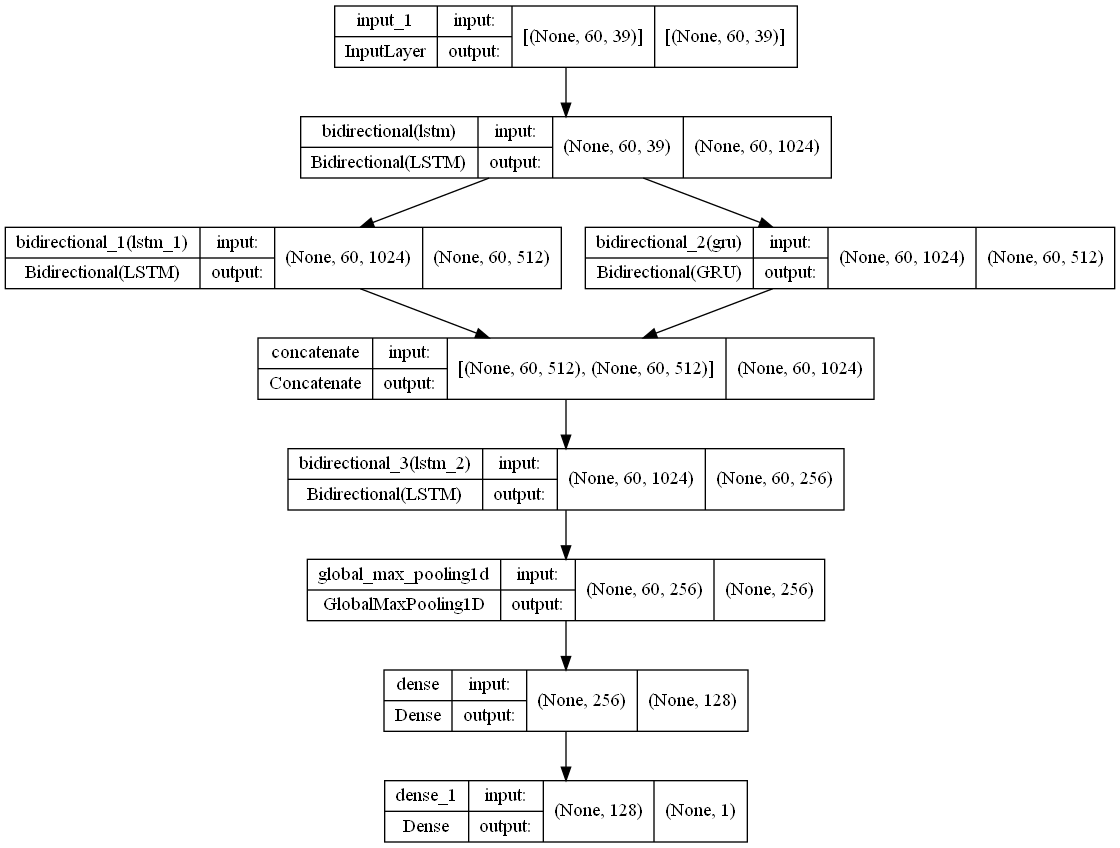

In [8]:
plot_model(
    model, 
    to_file='Super_Model.png', 
    show_shapes=True,
    show_layer_names=True
)